C:\Users\12066\AppData\Local\Temp\ipykernel_4380\1675754273.py:67: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")
C:\Users\12066\AppData\Local\Temp\ipykernel_4380\1675754273.py:95: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
C:\Users\12066\AppData\Local\Temp\ipykernel_4380\1675754273.py:123: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include

Saved: mall_kmeans_clusters.csv
cluster
0    14
1     3
2     1
3     2
Name: count, dtype: int64


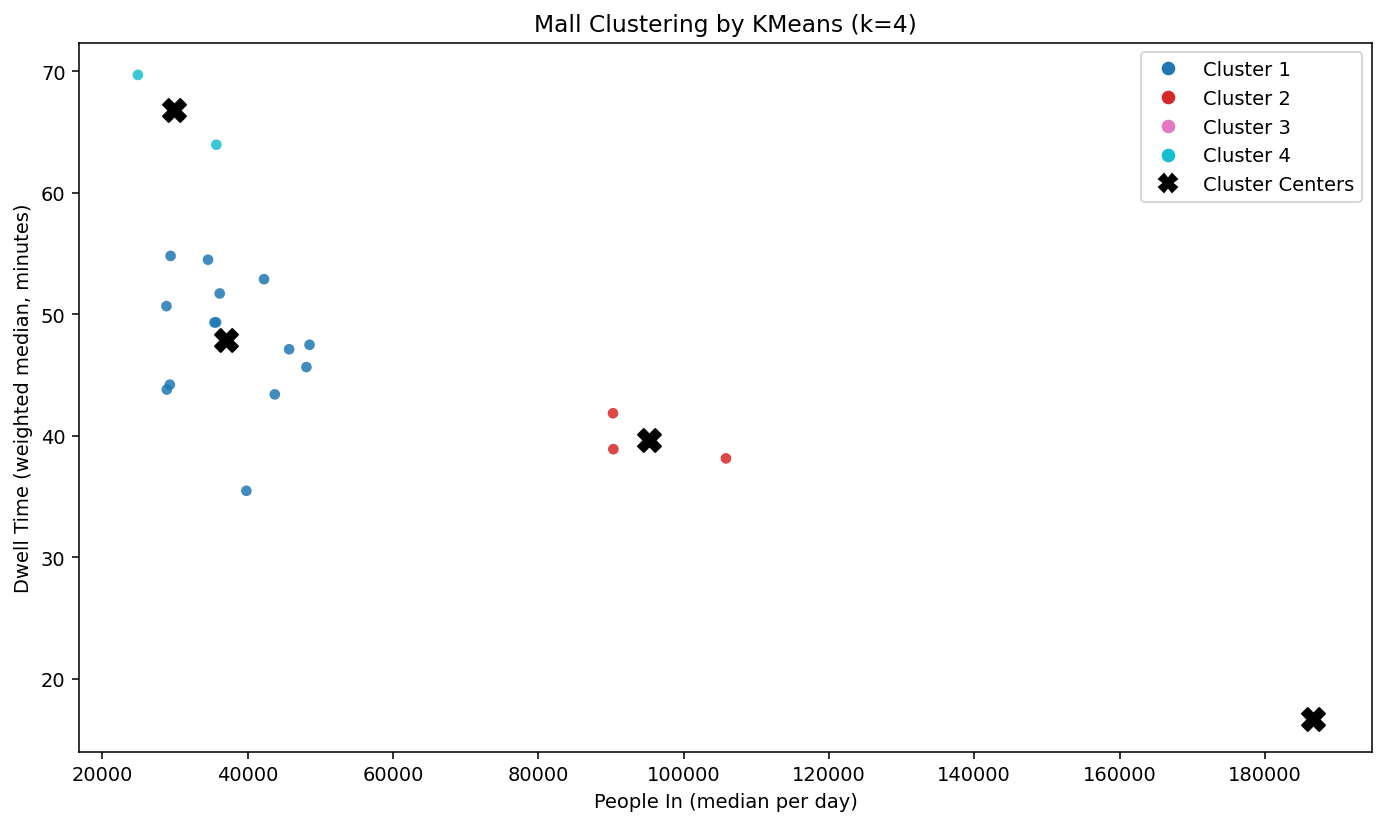

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# ======================
# Config (modify as needed)
# ======================
INPUT_PATH = "fact_malls_v1.csv"

HAS_INTRADAY_ROWS = True  # True if there are intraday multiple time points; False if already one row per mall per day
PEOPLE_IN_DAILY_METHOD = "sum"  # "sum" (incremental) or "max" (cumulative / snapshot)

MIN_SAMPLE_PER_DAY = 30
MIN_DAYS_PER_MALL = 14

N_CLUSTERS = 4            # Number of KMeans clusters (can be changed)
RANDOM_STATE = 42

# Whether to apply log1p to foot traffic (strongly recommended, traffic is usually long-tailed)
LOG_FLOW = True

OUT_CSV = "mall_kmeans_clusters.csv"
OUT_PNG = "mall_scatter_kmeans.png"

# ======================
# Helper functions
# ======================
def agg_people_in(s: pd.Series, method: str):
    if method == "sum":
        return s.sum(min_count=1)
    if method == "max":
        return s.max()
    raise ValueError("PEOPLE_IN_DAILY_METHOD must be 'sum' or 'max'")

def weighted_median(x, w):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    if m.sum() == 0:
        return np.nan

    x = x[m]
    w = w[m]
    order = np.argsort(x)
    x = x[order]
    w = w[order]

    cum_w = np.cumsum(w)
    cutoff = 0.5 * w.sum()
    idx = np.searchsorted(cum_w, cutoff, side="left")
    return float(x[min(idx, len(x) - 1)])

# ======================
# 1) Load + clean
# ======================
df = pd.read_csv(INPUT_PATH)

required = ["date","mall_id","people_in","average_dwell_time","median_dwell_time","dwell_time_sample"]
missing = set(required) - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date", "mall_id"]).copy()

for c in ["people_in","average_dwell_time","median_dwell_time","dwell_time_sample"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df[
    df["people_in"].ge(0)
    & df["average_dwell_time"].ge(0)
    & df["median_dwell_time"].ge(0)
    & df["dwell_time_sample"].ge(0)
].copy()

df["day"] = df["date"].dt.floor("D")

# ======================
# 2) intraday -> daily (one row per mall per day)
# ======================
if HAS_INTRADAY_ROWS:
    daily_people = (
        df.groupby(["mall_id", "day"])["people_in"]
          .apply(lambda s: agg_people_in(s, PEOPLE_IN_DAILY_METHOD))
          .rename("people_in_daily")
          .reset_index()
    )

    daily_dwell = (
        df.groupby(["mall_id", "day"])
          .apply(lambda g: pd.Series({
              "dwell_sample_daily": g["dwell_time_sample"].sum(min_count=1),
              "med_dwell_daily": weighted_median(g["median_dwell_time"], g["dwell_time_sample"]),
          }))
          .reset_index()
    )

    daily = daily_people.merge(daily_dwell, on=["mall_id","day"], how="left")
else:
    daily = df.rename(columns={
        "people_in": "people_in_daily",
        "dwell_time_sample": "dwell_sample_daily",
        "median_dwell_time": "med_dwell_daily",
    })[["mall_id","day","people_in_daily","dwell_sample_daily","med_dwell_daily"]].copy()

daily["valid_dwell"] = daily["dwell_sample_daily"] >= MIN_SAMPLE_PER_DAY

# ======================
# 3) daily -> mall (one row per mall)
# ======================
flow_profile = daily.groupby("mall_id").agg(
    days=("day", "nunique"),
    people_in_median=("people_in_daily", "median"),
).reset_index()

dwell_valid = daily[daily["valid_dwell"]].copy()
dwell_profile = (
    dwell_valid.groupby("mall_id")
    .apply(lambda g: pd.Series({
        "med_dwell_wmedian": weighted_median(g["med_dwell_daily"], g["dwell_sample_daily"]),
        "valid_dwell_days": g["day"].nunique(),
    }))
    .reset_index()
)

mall = flow_profile.merge(dwell_profile, on="mall_id", how="left")
mall["valid_dwell_rate"] = mall["valid_dwell_days"] / mall["days"]
mall = mall[mall["days"] >= MIN_DAYS_PER_MALL].copy()

# If there are no valid dwell days: you can choose to drop or fill.
# Here we drop them for cleaner results.
mall = mall.dropna(subset=["med_dwell_wmedian", "people_in_median"]).copy()

# ======================
# 4) KMeans clustering
# ======================
# Features: foot traffic (optionally log) + median dwell time
X_flow = np.log1p(mall["people_in_median"].values) if LOG_FLOW else mall["people_in_median"].values
X_dwell = mall["med_dwell_wmedian"].values

X = np.column_stack([X_flow, X_dwell])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

km = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init="auto")
mall["cluster"] = km.fit_predict(X_scaled)

# Compute cluster centers (converted back to readable original scale for plotting)
centers_scaled = km.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
center_flow = np.expm1(centers[:, 0]) if LOG_FLOW else centers[:, 0]
center_dwell = centers[:, 1]

# ======================
# 5) Output results
# ======================
out = mall[[
    "mall_id","cluster","people_in_median","med_dwell_wmedian","days","valid_dwell_rate"
]].sort_values(["cluster","mall_id"])

# Profiles: fixed naming based on current results (you can change the labels)
profile_map = {
    1: "Medium traffic - medium/long dwell (general-purpose mall)",
    2: "High traffic - medium dwell (efficient / quick-visit)",
    3: "Ultra-high traffic - short dwell (pass-through / quick in-out)",
    4: "Low traffic - long dwell (destination / experience-oriented)",
}

# Insert a profile column after cluster
out.insert(out.columns.get_loc("cluster") + 1, "profile",
           out["cluster"].map(profile_map).fillna("Undefined"))

out.to_csv(OUT_CSV, index=False)
print(f"Saved: {OUT_CSV}")
print(out["cluster"].value_counts().sort_index())

# ======================
# 6) Scatter plot (traffic vs dwell), colored by cluster
# ======================
plt.figure(figsize=(10, 6), dpi=140)

k = N_CLUSTERS
cmap = plt.get_cmap("tab10", k)  # discrete color map

# Scatter points
plt.scatter(
    mall["people_in_median"],
    mall["med_dwell_wmedian"],
    c=mall["cluster"],
    cmap=cmap,
    s=30,
    alpha=0.85,
    edgecolors="none"
)

# Cluster centers
plt.scatter(center_flow, center_dwell, c="black", s=140, marker="X", label="Cluster Centers")

plt.xlabel("People In (median per day)")
plt.ylabel("Dwell Time (weighted median, minutes)")
plt.title(f"Mall Clustering by KMeans (k={k})")

# Legend: one color per cluster
handles = [
    Line2D([0], [0], marker="o", linestyle="",
           markersize=7, markerfacecolor=cmap(i), markeredgecolor="none",
           label=f"Cluster {i+1}")
    for i in range(k)
]
handles.append(Line2D([0], [0], marker="X", linestyle="", color="black",
                      markersize=9, label="Cluster Centers"))

plt.legend(handles=handles, loc="best", frameon=True)

plt.tight_layout()
plt.savefig(OUT_PNG)
plt.show()

In [2]:
summary = mall.groupby("cluster").agg(
    n=("mall_id","count"),
    flow_med=("people_in_median","median"),
    flow_p25=("people_in_median", lambda s: s.quantile(0.25)),
    flow_p75=("people_in_median", lambda s: s.quantile(0.75)),
    dwell_med=("med_dwell_wmedian","median"),
    dwell_p25=("med_dwell_wmedian", lambda s: s.quantile(0.25)),
    dwell_p75=("med_dwell_wmedian", lambda s: s.quantile(0.75)),
).sort_index()

print(summary)

          n   flow_med    flow_p25    flow_p75  dwell_med  dwell_p25  \
cluster                                                                
0        14   35904.00   30681.750   43365.125   48.41665   44.57920   
1         3   90334.50   90309.250   98081.750   38.90830   38.52915   
2         1  186660.00  186660.000  186660.000   16.66670   16.66670   
3         2   30293.75   27593.875   32993.625   66.84170   65.40420   

         dwell_p75  
cluster             
0        51.464575  
1        40.387500  
2        16.666700  
3        68.279200  


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

INPUT_PATH  = "full_info_stores.csv"
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)
df = pd.read_csv(INPUT_PATH )

In [4]:
num_cols = [
    "gla", "sales_eur", "costs_eur", "sri_score",
    "store_yearly_people_in"
]

for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["mall_id", "store_code"])

In [5]:
mall_kpi = (
    df.groupby("mall_id")
    .agg(
        n_stores=("store_code", "nunique"),
        total_sales_eur=("sales_eur", "sum"),
        total_costs_eur=("costs_eur", "sum"),
        total_gla=("gla", "sum"),
        avg_sri=("sri_score", "mean"),
    )
    .reset_index()
)

mall_kpi["gross_margin"] = mall_kpi["total_sales_eur"] - mall_kpi["total_costs_eur"]
mall_kpi["sales_per_sqm"] = mall_kpi["total_sales_eur"] / mall_kpi["total_gla"]
mall_kpi["sales_per_store"] = mall_kpi["total_sales_eur"] / mall_kpi["n_stores"]

mall_kpi.to_csv(OUT_DIR / "01_mall_kpi_overview.csv", index=False)
print("Saved 01_mall_kpi_overview.csv")

Saved 01_mall_kpi_overview.csv


In [6]:
mix_bl1 = (
    df.groupby(["mall_id", "bl1_label"])
    .agg(
        stores=("store_code", "nunique"),
        sales=("sales_eur", "sum"),
        gla=("gla", "sum"),
    )
    .reset_index()
)

mix_bl1["store_share"] = mix_bl1["stores"] / mix_bl1.groupby("mall_id")["stores"].transform("sum")
mix_bl1["sales_share"] = mix_bl1["sales"] / mix_bl1.groupby("mall_id")["sales"].transform("sum")
mix_bl1["gla_share"] = mix_bl1["gla"] / mix_bl1.groupby("mall_id")["gla"].transform("sum")

mix_bl1.to_csv(OUT_DIR / "02_mall_tenant_mix_bl1.csv", index=False)
print("Saved 02_mall_tenant_mix_bl1.csv")

Saved 02_mall_tenant_mix_bl1.csv


In [7]:
eff_bl1 = (
    df.groupby(["mall_id", "bl1_label"])
    .agg(
        sales=("sales_eur", "sum"),
        gla=("gla", "sum"),
        stores=("store_code", "nunique"),
    )
    .reset_index()
)

eff_bl1["sales_per_sqm"] = eff_bl1["sales"] / eff_bl1["gla"]
eff_bl1["sales_per_store"] = eff_bl1["sales"] / eff_bl1["stores"]

eff_bl1.to_csv(OUT_DIR / "04_mall_efficiency_by_bl1.csv", index=False)
print("Saved 04_mall_efficiency_by_bl1.csv")

Saved 04_mall_efficiency_by_bl1.csv


In [8]:
traffic_eff = (
    df.groupby(["mall_id", "bl1_label"])
    .agg(
        sales=("sales_eur", "sum"),
        people=("store_yearly_people_in", "sum"),
    )
    .reset_index()
)

traffic_eff["sales_per_visitor"] = traffic_eff["sales"] / traffic_eff["people"]

traffic_eff.to_csv(OUT_DIR / "05_mall_traffic_efficiency.csv", index=False)
print("Saved 05_mall_traffic_efficiency.csv")

Saved 05_mall_traffic_efficiency.csv


In [9]:
from pathlib import Path
import pandas as pd

OUT_DIR = Path("outputs")

mall_kpi = pd.read_csv(OUT_DIR / "01_mall_kpi_overview.csv")
clusters = pd.read_csv("mall_kmeans_clusters.csv")

mall_kpi_cluster = mall_kpi.merge(
    clusters[["mall_id", "cluster", "profile", "people_in_median", "med_dwell_wmedian"]],
    on="mall_id",
    how="left"
)

mall_kpi_cluster.to_csv(
    OUT_DIR / "06_mall_kpi_with_cluster.csv",
    index=False
)

print("Saved 06_mall_kpi_with_cluster.csv")

Saved 06_mall_kpi_with_cluster.csv


In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler

df = mall_kpi_cluster.copy()

features = ["total_sales_eur", "sales_per_sqm"]
X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

typical_rows = []

for c in df["cluster"].dropna().unique():
    idx = df["cluster"] == c
    center = X_scaled[idx].mean(axis=0)
    dist = np.linalg.norm(X_scaled[idx] - center, axis=1)
    typical = df[idx].iloc[dist.argmin()]
    typical_rows.append(typical)

typical_malls = pd.DataFrame(typical_rows)

typical_malls.to_csv(
    OUT_DIR / "07_cluster_typical_malls.csv",
    index=False
)

print("Saved 07_cluster_typical_malls.csv")

Saved 07_cluster_typical_malls.csv


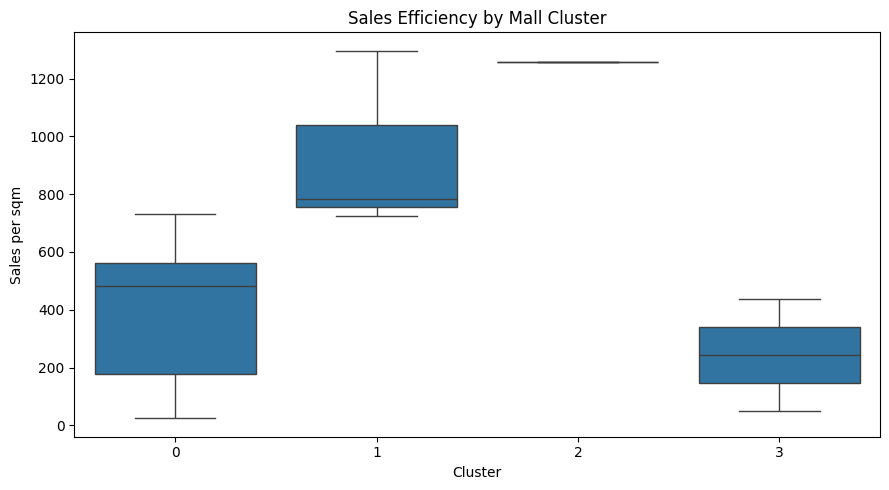

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

df = mall_kpi_cluster.copy()
Path("outputs/figures").mkdir(exist_ok=True)

plt.figure(figsize=(9,5))
sns.boxplot(
    data=df,
    x="cluster",
    y="sales_per_sqm"
)
plt.title("Sales Efficiency by Mall Cluster")
plt.ylabel("Sales per sqm")
plt.xlabel("Cluster")
plt.tight_layout()
plt.savefig("outputs/figures/fig01_cluster_kpi_boxplot.png")
plt.show()

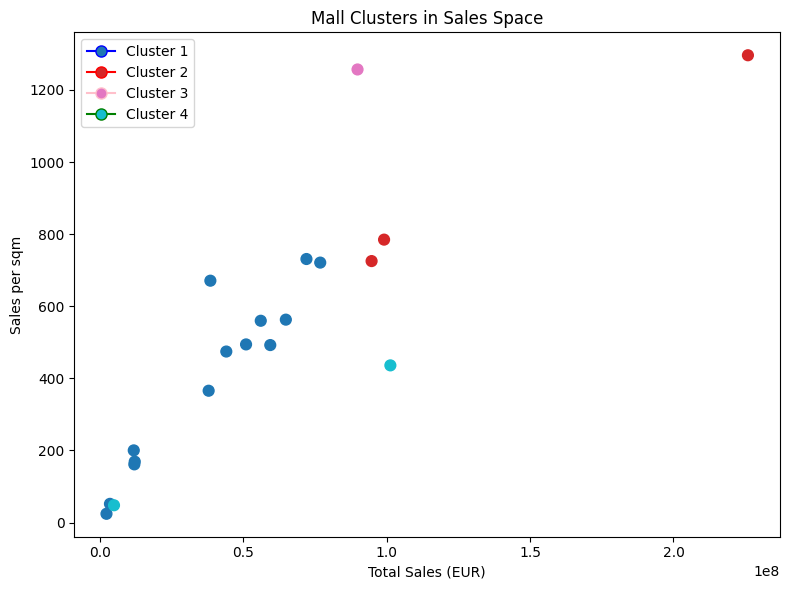

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(
    df["total_sales_eur"],
    df["sales_per_sqm"],
    c=df["cluster"],
    cmap="tab10",
    s=60
)

legend_elements = [
    Line2D([0], [0], marker='o', color='blue', label='Cluster 1',
           markerfacecolor='tab:blue', markersize=8),
    Line2D([0], [0], marker='o', color='red', label='Cluster 2',
           markerfacecolor='tab:red', markersize=8),
    Line2D([0], [0], marker='o', color='pink', label='Cluster 3',
           markerfacecolor='tab:pink', markersize=8),
    Line2D([0], [0], marker='o', color='green', label='Cluster 4',
           markerfacecolor='tab:cyan', markersize=8),
]

plt.legend(handles=legend_elements)
plt.xlabel("Total Sales (EUR)")
plt.ylabel("Sales per sqm")
plt.title("Mall Clusters in Sales Space")
plt.tight_layout()
plt.savefig("outputs/figures/fig02_cluster_sales_vs_dwell.png")
plt.show()



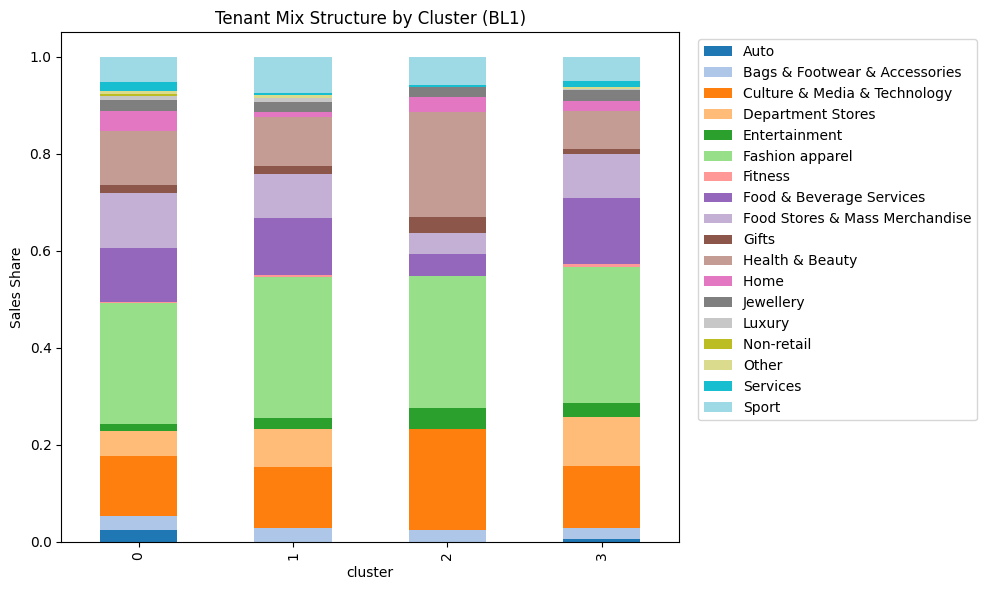

In [13]:
mix_bl1 = pd.read_csv(OUT_DIR / "02_mall_tenant_mix_bl1.csv")
mix_bl1 = mix_bl1.merge(
    clusters[["mall_id", "cluster"]],
    on="mall_id",
    how="left"
)

cluster_mix = (
    mix_bl1
    .groupby(["cluster", "bl1_label"])
    .agg(sales_share=("sales_share", "mean"))
    .reset_index()
)


cluster_mix["sales_share_norm"] = (
    cluster_mix
    .groupby("cluster")["sales_share"]
    .transform(lambda x: x / x.sum())
)

pivot = cluster_mix.pivot(
    index="cluster",
    columns="bl1_label",
    values="sales_share_norm"
).fillna(0)

pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    colormap="tab20"
)

plt.ylabel("Sales Share")
plt.title("Tenant Mix Structure by Cluster (BL1)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("outputs/figures/fig03_cluster_tenant_mix_bl1.png")
plt.show()

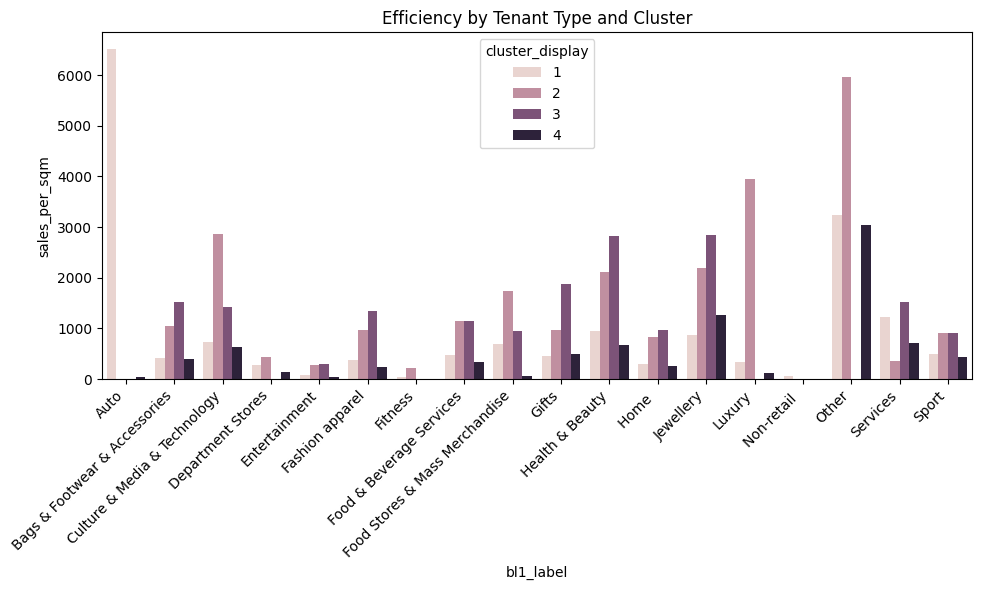

In [14]:
eff = pd.read_csv(OUT_DIR / "04_mall_efficiency_by_bl1.csv")
eff = eff.merge(
    clusters[["mall_id", "cluster"]],
    on="mall_id",
    how="left"
)

eff_cluster = (
    eff.groupby(["cluster", "bl1_label"])
    .agg(sales_per_sqm=("sales_per_sqm", "mean"))
    .reset_index()
)

# Add display cluster (1-4 instead of 0-3)
eff_cluster["cluster_display"] = eff_cluster["cluster"] + 1

plt.figure(figsize=(10,6))
sns.barplot(
    data=eff_cluster,
    x="bl1_label",
    y="sales_per_sqm",
    hue="cluster_display"
)
plt.xticks(rotation=45, ha="right")
plt.title("Efficiency by Tenant Type and Cluster")
plt.tight_layout()
plt.savefig("outputs/figures/fig04_cluster_efficiency_bl1.png")
plt.show()

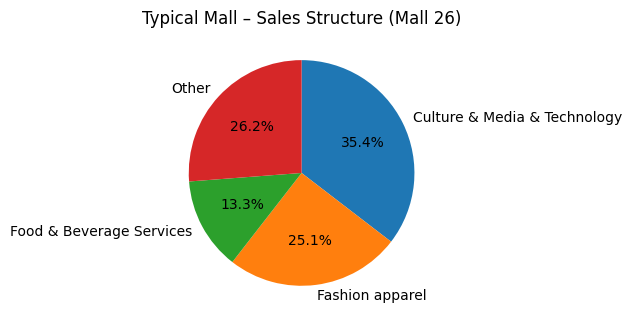

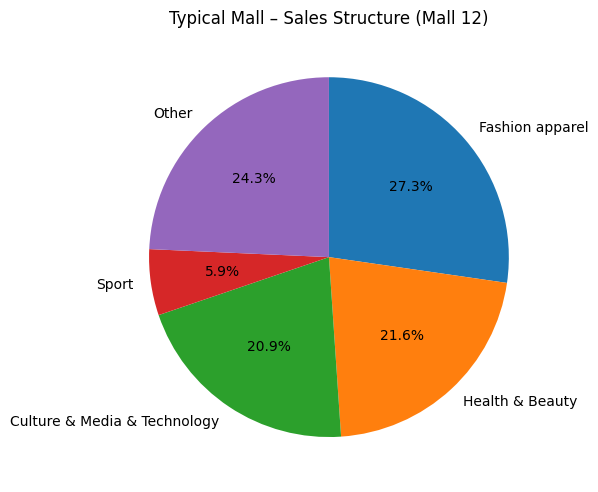

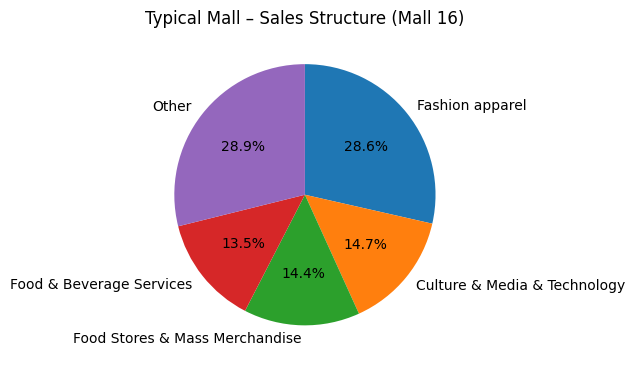

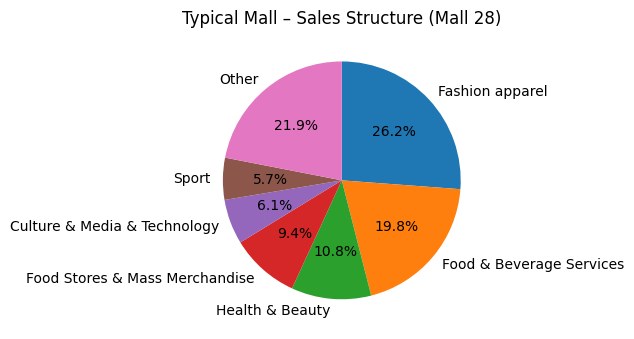

In [15]:
typical_ids = typical_malls["mall_id"].tolist()
df_full = pd.read_csv("full_info_stores.csv")

for mid in typical_ids:
    sub = df_full[df_full["mall_id"] == mid]

   
    structure = (
        sub.groupby("bl1_label")
        .agg(sales=("sales_eur", "sum"))
        .sort_values("sales", ascending=False)
    )

    structure["share"] = structure["sales"] / structure["sales"].sum()

    structure["cum_share"] = structure["share"].cumsum()

    main = structure[structure["cum_share"] <= 0.8].copy()
    other_share = structure.loc[structure["cum_share"] > 0.8, "share"].sum()

    if other_share > 0:
        main.loc["Other"] = {
            "sales": structure["sales"].sum() * other_share,
            "share": other_share,
            "cum_share": 1.0
        }

    main["share"].plot(
        kind="pie",
        autopct="%.1f%%",
        startangle=90,
        counterclock=False,
        ylabel="",
        figsize=(6, 6)
    )

    plt.title(f"Typical Mall – Sales Structure (Mall {mid})")
    plt.tight_layout()
    plt.savefig(f"outputs/figures/fig05_mall_{mid}_sales_structure.png")
    plt.show()

In [16]:
# Question 1️⃣: Which types of malls are worth building?
# Analyze the financial performance and overall strength of each cluster

print("="*60)
print("Question 1️⃣: Which types of malls are worth building?")
print("="*60)

# Load data
mall_kpi_cluster = pd.read_csv(OUT_DIR / "06_mall_kpi_with_cluster.csv")
clusters = pd.read_csv("mall_kmeans_clusters.csv")

# Calculate average KPIs by cluster
cluster_performance = (
    mall_kpi_cluster.groupby("cluster").agg(
        n_malls=("mall_id", "count"),
        avg_traffic=("people_in_median", "mean"),
        avg_dwell=("med_dwell_wmedian", "mean"),
        avg_sales=("total_sales_eur", "mean"),
        avg_sales_per_sqm=("sales_per_sqm", "mean"),
        avg_gla=("total_gla", "mean"),
        avg_margin=("gross_margin", "mean"),
        avg_margin_rate=("gross_margin", lambda x: (x / mall_kpi_cluster.loc[x.index, "total_sales_eur"]).mean()),
        avg_stores=("n_stores", "mean"),
    ).round(2)
)

# Define cluster business-type descriptions
cluster_desc = {
    0: "Medium traffic – medium/long dwell (general-purpose)",
    1: "High traffic – medium dwell (fast-turnover)", 
    2: "Ultra-high traffic – short dwell (commuter-oriented)",
    3: "Low traffic – long dwell (destination-focused)",
}

cluster_performance["profile"] = cluster_performance.index.map(cluster_desc)

print("\nOverall performance comparison by cluster:\n")
print(cluster_performance[["profile", "n_malls", "avg_traffic", "avg_dwell", 
                           "avg_sales", "avg_sales_per_sqm", "avg_margin_rate"]])

# Calculate investment return indicator
cluster_performance["roi_score"] = (
    (cluster_performance["avg_sales_per_sqm"] * 100) * 
    (cluster_performance["avg_margin_rate"] * 100) / 10000
).round(2)

print("\n\n📊 Investment attractiveness score (sales efficiency × margin rate):\n")
roi_ranking = cluster_performance[["profile", "avg_sales_per_sqm", "avg_margin_rate", "roi_score"]].sort_values("roi_score", ascending=False)
print(roi_ranking)

print("\n\n✨ Recommendation:")
best_cluster = roi_ranking.iloc[0]
worst_cluster = roi_ranking.iloc[-1]
print(f"  ✅ {best_cluster['profile']} (Cluster {best_cluster.name}): Most suitable for new development")
print(f"     - Sales per sqm: €{best_cluster['avg_sales_per_sqm']:.2f}/sqm")
print(f"     - Margin rate: {best_cluster['avg_margin_rate']*100:.1f}%")
print(f"     - ROI score: {best_cluster['roi_score']:.2f}")

print(f"\n  ⚠️  {worst_cluster['profile']} (Cluster {worst_cluster.name}): Build with caution")
print(f"     - Despite long dwell time, sales efficiency is relatively low")
print(f"     - Requires improvement in footfall or sales conversion")

Question 1️⃣: Which types of malls are worth building?

Overall performance comparison by cluster:

                                                   profile  n_malls  \
cluster                                                               
0        Medium traffic – medium/long dwell (general-pu...       14   
1              High traffic – medium dwell (fast-turnover)        3   
2        Ultra-high traffic – short dwell (commuter-ori...        1   
3           Low traffic – long dwell (destination-focused)        2   

         avg_traffic  avg_dwell     avg_sales  avg_sales_per_sqm  \
cluster                                                            
0           37591.89      47.90  3.873898e+07             405.71   
1           95482.50      39.64  1.399247e+08             935.44   
2          186660.00      16.67  8.982851e+07            1256.76   
3           30293.75      66.84  5.309566e+07             242.09   

         avg_margin_rate  
cluster                   
0         


Question 2️⃣: What should the tenant mix look like for new developments?

Cluster 0 - Medium traffic – medium/long dwell (general-purpose)
Sample size: 14 malls

Tenant mix benchmarking (Top 10):

                                stores  pct_stores        gla  pct_sales  \
bl1_label                                                                  
Fashion apparel                    626        24.6  364002.69       24.7   
Culture & Media & Technology       161         6.3   92205.87       14.2   
Food Stores & Mass Merchandise      38         1.5  177241.07       13.5   
Health & Beauty                    349        13.7   71855.86       12.1   
Food & Beverage Services           550        21.6  124160.55       11.0   
Sport                              113         4.4   69039.15        5.9   
Home                                98         3.9   70800.15        4.1   
Department Stores                    6         0.2   62305.80        3.4   
Bags & Footwear & Accessories      181    

C:\Users\12066\AppData\Local\Temp\ipykernel_4380\2112472310.py:24: RuntimeWarning: invalid value encountered in scalar divide
  avg_sales_per_store=("sales_eur", lambda x: x.sum() / x.nunique()),


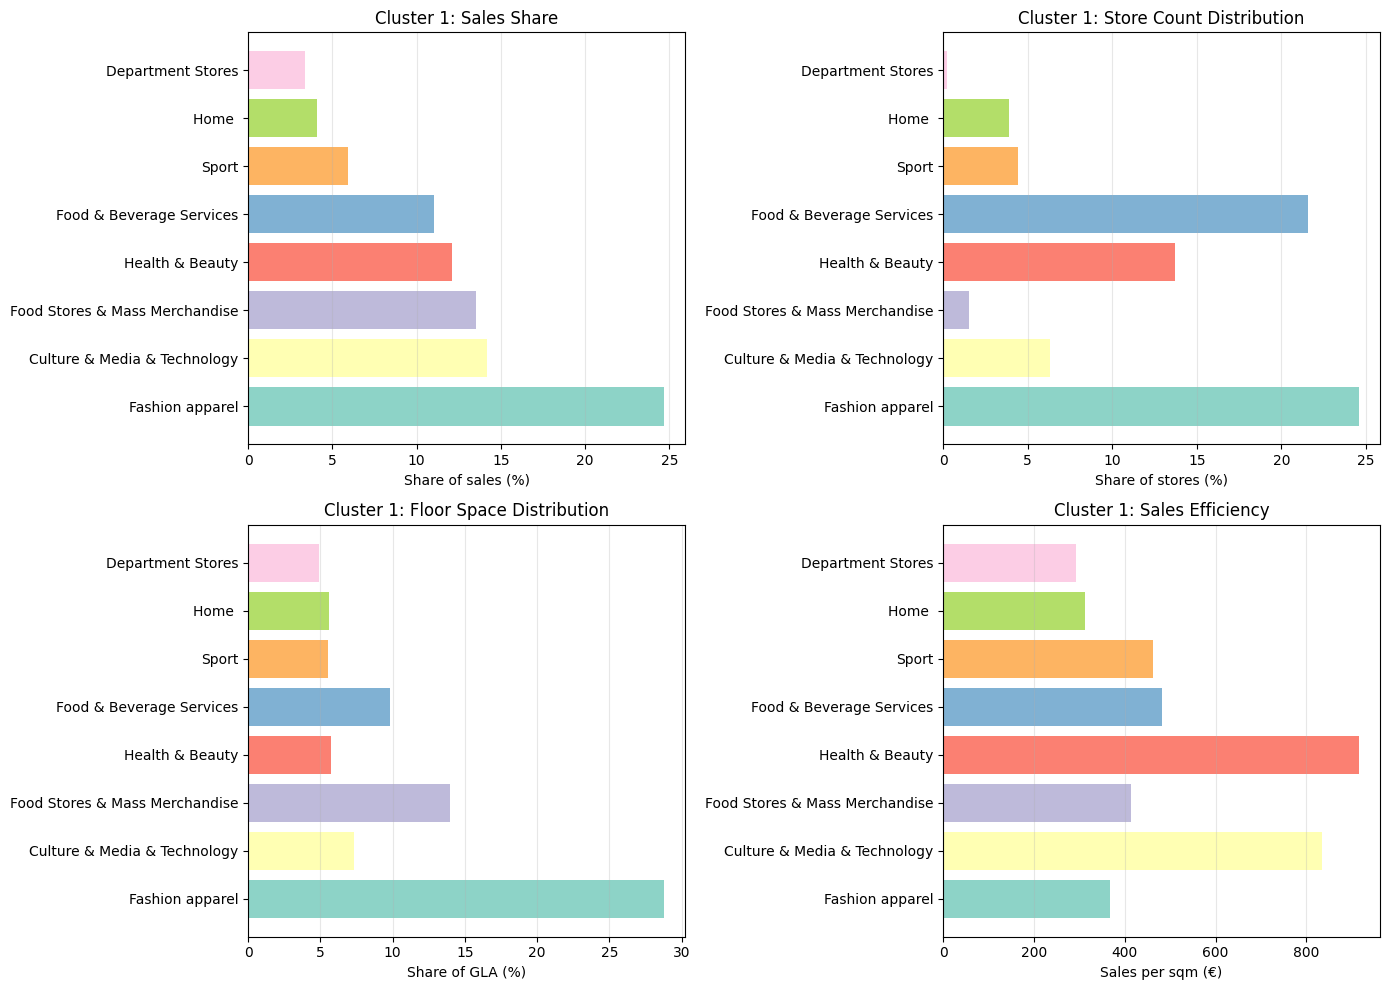


Cluster 1 - High traffic – medium dwell (fast-turnover)
Sample size: 3 malls

Tenant mix benchmarking (Top 10):

                                stores  pct_stores        gla  pct_sales  \
bl1_label                                                                  
Fashion apparel                    165        23.3  129496.62       32.2   
Culture & Media & Technology        36         5.1   22834.76       12.8   
Food & Beverage Services           200        28.2   43572.67       12.1   
Health & Beauty                     87        12.3   20222.25       10.5   
Food Stores & Mass Merchandise       8         1.1   35908.25        7.3   
Department Stores                    3         0.4   61297.38        7.1   
Sport                               32         4.5   30641.08        6.6   
Bags & Footwear & Accessories       57         8.1   11886.81        3.0   
Entertainment                        8         1.1   45169.74        2.7   
Jewellery                           32         4.5

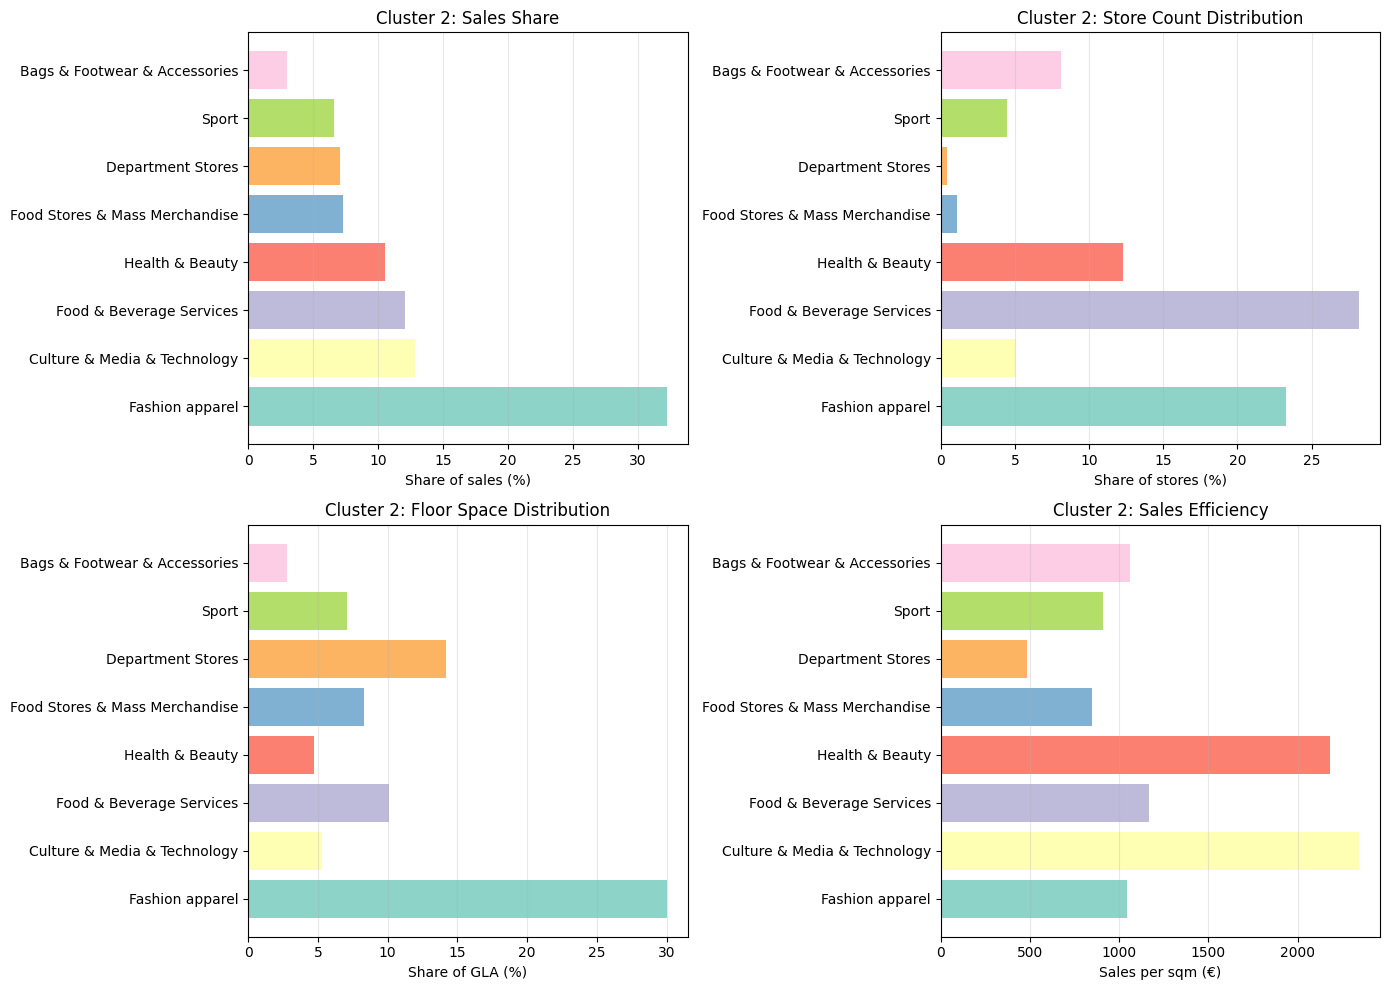


Cluster 2 - Ultra-high traffic – short dwell (commuter-oriented)
Sample size: 1 malls

Tenant mix benchmarking (Top 10):

                                stores  pct_stores       gla  pct_sales  \
bl1_label                                                                 
Fashion apparel                     31        22.8  18308.56       27.3   
Health & Beauty                     24        17.6   6875.40       21.6   
Culture & Media & Technology         6         4.4  13195.00       20.9   
Sport                                6         4.4   5832.00        5.9   
Food & Beverage Services            27        19.9   3621.10        4.6   
Entertainment                        1         0.7  12892.50        4.2   
Food Stores & Mass Merchandise       1         0.7   3926.00        4.2   
Gifts                                7         5.1   1586.00        3.3   
Home                                 5         3.7   2939.00        3.2   
Bags & Footwear & Accessories       15        11.0  

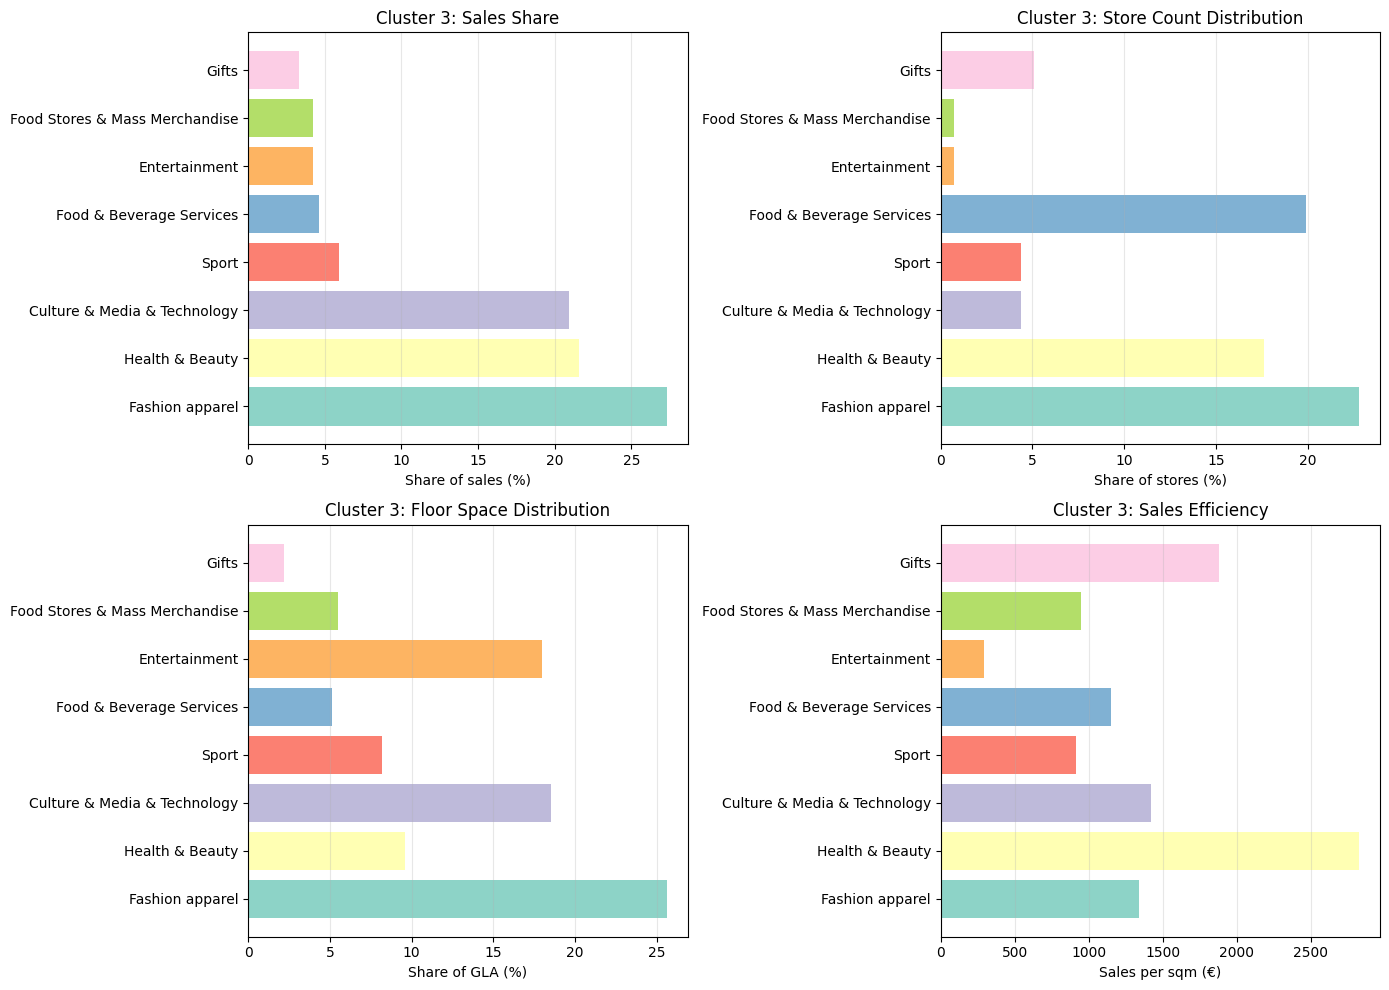


Cluster 3 - Low traffic – long dwell (destination-focused)
Sample size: 2 malls

Tenant mix benchmarking (Top 10):

                               stores  pct_stores       gla  pct_sales  \
bl1_label                                                                
Fashion apparel                    98        26.5  104892.0       32.4   
Culture & Media & Technology       21         5.7   22279.0       20.4   
Department Stores                   3         0.8   76320.0       16.5   
Food & Beverage Services           95        25.7   33866.0        9.6   
Health & Beauty                    47        12.7    9845.0        5.6   
Sport                              18         4.9   10754.0        4.8   
Jewellery                          18         4.9    1803.0        2.9   
Entertainment                       7         1.9   46141.5        2.7   
Bags & Footwear & Accessories      22         5.9    5535.0        2.2   
Home                               17         4.6    7915.0        1.

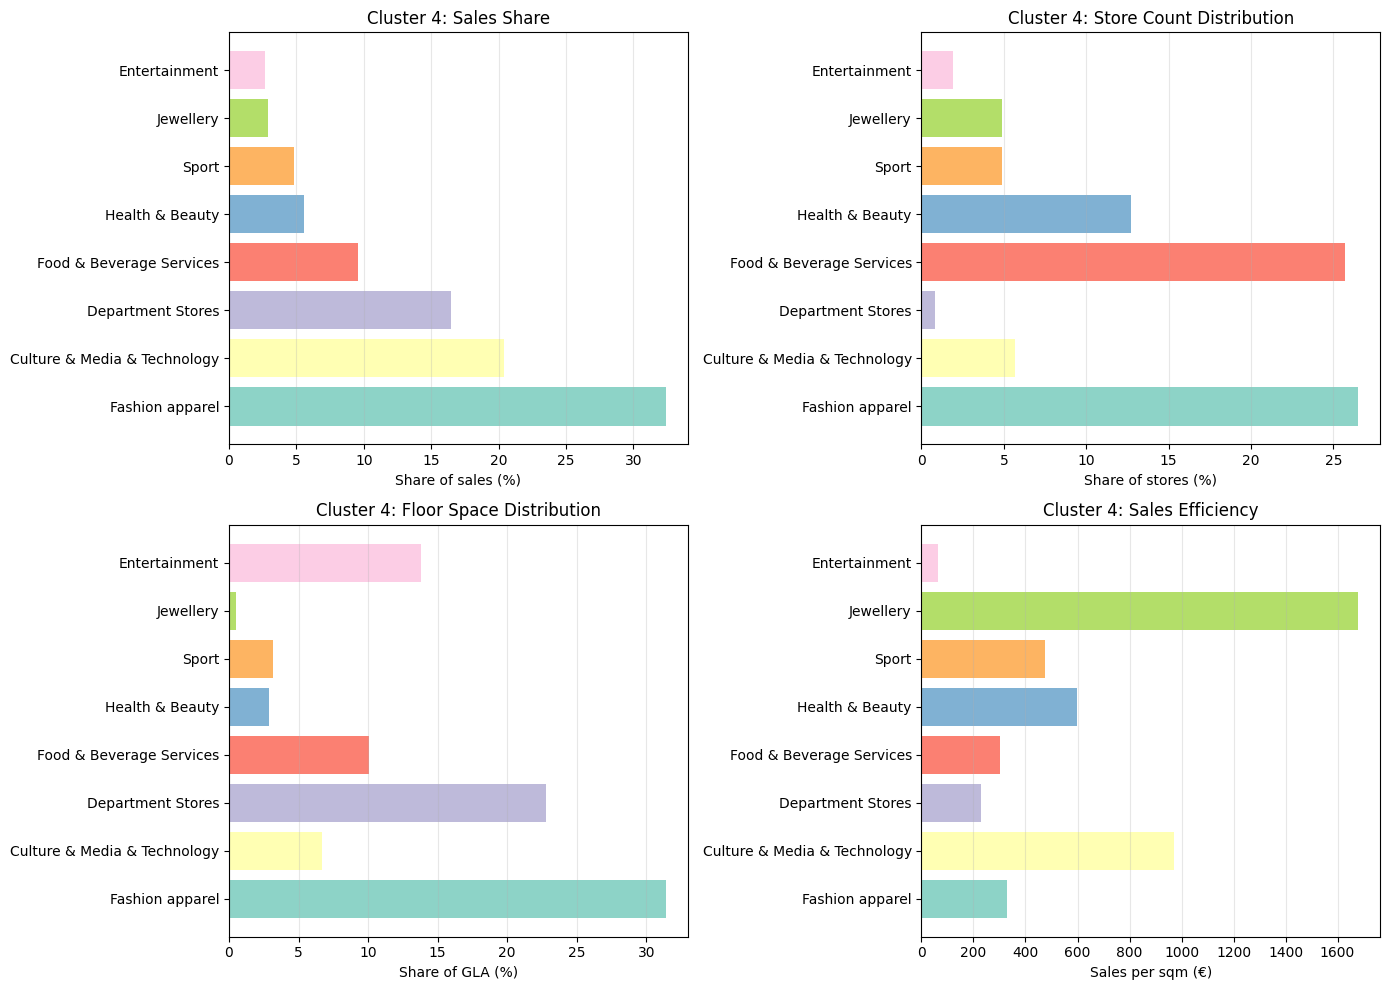



✅ Tenant mix analysis complete for all clusters


In [17]:
# Question 2️⃣: What should the tenant mix look like for new developments?
# Analyze the tenant mix configuration for EACH cluster

print("\n" + "="*60)
print("Question 2️⃣: What should the tenant mix look like for new developments?")
print("="*60)

# Load full store-level data
df_stores = pd.read_csv("full_info_stores.csv")

# Analyze tenant mix for each cluster
cluster_mix_analysis = {}

for cluster_id in sorted(mall_kpi_cluster["cluster"].dropna().unique()):
    cluster_malls = mall_kpi_cluster[mall_kpi_cluster["cluster"] == cluster_id]["mall_id"].tolist()
    cluster_stores = df_stores[df_stores["mall_id"].isin(cluster_malls)]
    
    # Aggregate by category (BL1)
    bl1_structure = (
        cluster_stores.groupby("bl1_label").agg(
            stores=("store_code", "nunique"),
            gla=("gla", "sum"),
            sales=("sales_eur", "sum"),
            avg_sales_per_store=("sales_eur", lambda x: x.sum() / x.nunique()),
        ).sort_values("sales", ascending=False)
    )
    
    bl1_structure["pct_stores"] = (bl1_structure["stores"] / bl1_structure["stores"].sum() * 100).round(1)
    bl1_structure["pct_sales"] = (bl1_structure["sales"] / bl1_structure["sales"].sum() * 100).round(1)
    bl1_structure["pct_gla"] = (bl1_structure["gla"] / bl1_structure["gla"].sum() * 100).round(1)
    bl1_structure["sales_per_sqm"] = (bl1_structure["sales"] / bl1_structure["gla"]).round(2)
    
    # Identify optimal mix using the 80/20 rule
    cumsum_sales = bl1_structure["pct_sales"].cumsum()
    core_categories = cumsum_sales[cumsum_sales <= 80].index.tolist()
    
    cluster_mix_analysis[cluster_id] = {
        "structure": bl1_structure,
        "core_categories": core_categories,
        "n_malls": len(cluster_malls),
    }

# Display results for each cluster
for idx, cluster_id in enumerate(sorted(cluster_mix_analysis.keys())):
    info = cluster_mix_analysis[cluster_id]
    bl1_structure = info["structure"]
    core_categories = info["core_categories"]
    
    print(f"\n{'='*60}")
    print(f"Cluster {int(cluster_id)} - {cluster_desc[cluster_id]}")
    print(f"Sample size: {info['n_malls']} malls")
    print(f"{'='*60}")
    
    print(f"\nTenant mix benchmarking (Top 10):\n")
    print(bl1_structure.head(10)[["stores", "pct_stores", "gla", "pct_sales", "sales_per_sqm", "avg_sales_per_store"]])
    
    print(f"\n🎯 Recommended core tenant mix (contributing 80% of sales):\n")
    core_mix = bl1_structure.loc[core_categories].copy()
    print(core_mix[["stores", "pct_stores", "pct_sales", "sales_per_sqm"]])
    
    print(f"\n✨ Configuration guidelines:")
    print(f"  • Core categories (80% of sales): {len(core_categories)}")
    print(f"  • Suggested share of stores: {core_mix['pct_stores'].sum():.1f}%")
    print(f"  • Non-core categories fill space and enhance diversity")
    
    # Create 2x2 subplot for each cluster showing different metrics
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    top_cats = bl1_structure.head(8)
    colors = plt.cm.Set3(range(len(top_cats)))
    
    # Chart 1: Sales Share (pct_sales)
    axes[0].barh(range(len(top_cats)), top_cats["pct_sales"].values, color=colors)
    axes[0].set_yticks(range(len(top_cats)))
    axes[0].set_yticklabels(top_cats.index)
    axes[0].set_xlabel("Share of sales (%)")
    axes[0].set_title(f"Cluster {int(cluster_id)+1}: Sales Share")
    axes[0].grid(axis='x', alpha=0.3)
    
    # Chart 2: Store Count Share (pct_stores)
    axes[1].barh(range(len(top_cats)), top_cats["pct_stores"].values, color=colors)
    axes[1].set_yticks(range(len(top_cats)))
    axes[1].set_yticklabels(top_cats.index)
    axes[1].set_xlabel("Share of stores (%)")
    axes[1].set_title(f"Cluster {int(cluster_id)+1}: Store Count Distribution")
    axes[1].grid(axis='x', alpha=0.3)
    
    # Chart 3: GLA Share (pct_gla)
    axes[2].barh(range(len(top_cats)), top_cats["pct_gla"].values, color=colors)
    axes[2].set_yticks(range(len(top_cats)))
    axes[2].set_yticklabels(top_cats.index)
    axes[2].set_xlabel("Share of GLA (%)")
    axes[2].set_title(f"Cluster {int(cluster_id)+1}: Floor Space Distribution")
    axes[2].grid(axis='x', alpha=0.3)
    
    # Chart 4: Sales per sqm (efficiency)
    axes[3].barh(range(len(top_cats)), top_cats["sales_per_sqm"].values, color=colors)
    axes[3].set_yticks(range(len(top_cats)))
    axes[3].set_yticklabels(top_cats.index)
    axes[3].set_xlabel("Sales per sqm (€)")
    axes[3].set_title(f"Cluster {int(cluster_id)+1}: Sales Efficiency")
    axes[3].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUT_DIR / "figures" / f"fig06_cluster_{int(cluster_id)}_tenant_mix_detail.png", dpi=100, bbox_inches='tight')
    plt.show()

print(f"\n\n✅ Tenant mix analysis complete for all clusters")


Question 3️⃣: How would each cluster's OTHER malls improve by adopting best-in-cluster mix?

Cluster-by-cluster optimization (within-cluster benchmarking):


Cluster 0 - Medium traffic – medium/long dwell (general-purpose)
  Sample: 14 malls
  Benchmark mall: 17 (sales/sqm: €731.06)
  Current avg efficiency: €429.07/sqm | Margin: 87.5%
  Target efficiency: €504.57/sqm (+17.6%)
  Target margin: 88.2% (+0.7pp)
  Expected sales uplift: €95,430,121 (+17.6%)
  Expected profit uplift: €87,841,777


Cluster 1 - High traffic – medium dwell (fast-turnover)
  Sample: 3 malls
  Benchmark mall: 32 (sales/sqm: €1296.17)
  Current avg efficiency: €973.54/sqm | Margin: 89.2%
  Target efficiency: €1054.20/sqm (+8.3%)
  Target margin: 89.7% (+0.4pp)
  Expected sales uplift: €34,777,590 (+8.3%)
  Expected profit uplift: €33,008,038


Cluster 2 - Ultra-high traffic – short dwell (commuter-oriented)
  Sample: 1 malls
  Benchmark mall: 12 (sales/sqm: €1256.76)
  Current avg efficiency: €1256.76/sqm | Marg

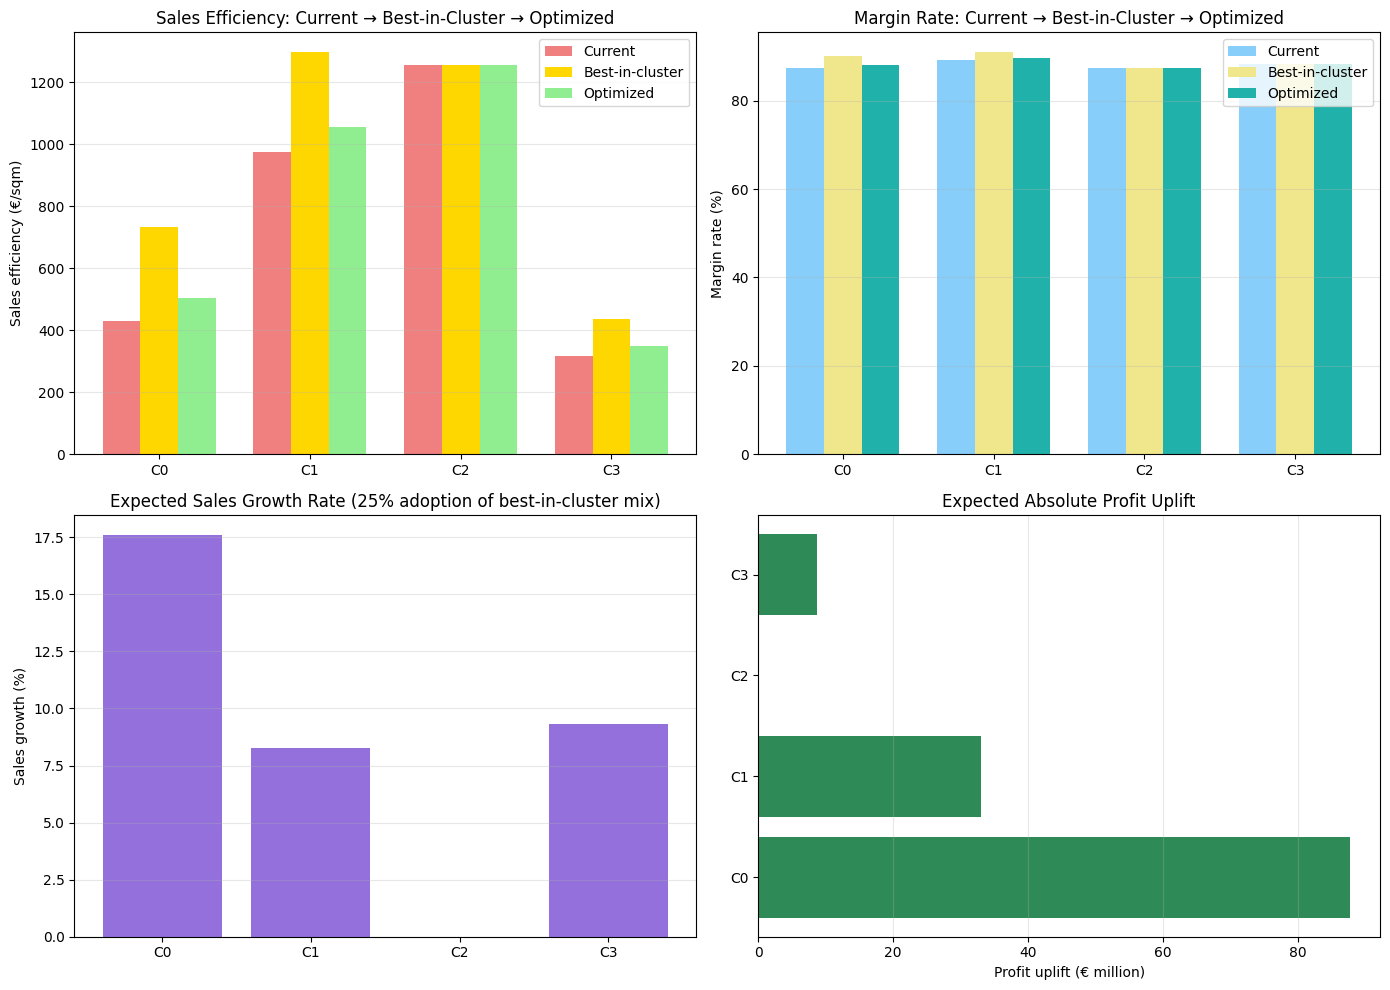


✅ Optimization analysis saved to 08_cluster_optimization_simulation.csv


In [18]:
# Question 3️⃣: How would overall performance change after optimizing existing malls?
# Simulate the impact of tenant mix optimization within each cluster

print("\n" + "="*60)
print("Question 3️⃣: How would each cluster's OTHER malls improve by adopting best-in-cluster mix?")
print("="*60)

# Load full store-level data
df_stores_full = pd.read_csv("full_info_stores.csv")
num_cols = ["gla", "sales_eur", "costs_eur", "sri_score", "store_yearly_people_in"]
for c in num_cols:
    if c in df_stores_full.columns:
        df_stores_full[c] = pd.to_numeric(df_stores_full[c], errors="coerce")

# Optimization results aggregated by cluster
optimization_results = []

print("\nCluster-by-cluster optimization (within-cluster benchmarking):\n")

for cluster_id in sorted(mall_kpi_cluster["cluster"].dropna().unique()):
    cluster_malls = mall_kpi_cluster[mall_kpi_cluster["cluster"] == cluster_id]["mall_id"].tolist()
    cluster_stores = df_stores_full[df_stores_full["mall_id"].isin(cluster_malls)]
    
    # Current aggregate state for this cluster
    current_sales = cluster_stores["sales_eur"].sum()
    current_gla = cluster_stores["gla"].sum()
    current_costs = cluster_stores["costs_eur"].sum()
    current_efficiency = current_sales / current_gla if current_gla > 0 else 0
    current_margin = (current_sales - current_costs) / current_sales if current_sales > 0 else 0
    
    # Use the BEST mall in this cluster as the benchmark
    best_mall_in_cluster = mall_kpi_cluster[
        mall_kpi_cluster["cluster"] == cluster_id
    ].nlargest(1, "sales_per_sqm")["mall_id"].values
    
    if len(best_mall_in_cluster) > 0:
        best_mall_id = best_mall_in_cluster[0]
        best_mall_stores = df_stores_full[df_stores_full["mall_id"] == best_mall_id]
        
        # Benchmark: best mall's efficiency and margin
        reference_sales = best_mall_stores["sales_eur"].sum()
        reference_gla = best_mall_stores["gla"].sum()
        reference_costs = best_mall_stores["costs_eur"].sum()
        reference_efficiency = reference_sales / reference_gla if reference_gla > 0 else 0
        reference_margin = (reference_sales - reference_costs) / reference_sales if reference_sales > 0 else 0
        
        print(f"\nCluster {int(cluster_id)} - {cluster_desc[cluster_id]}")
        print(f"  Sample: {len(cluster_malls)} malls")
        print(f"  Benchmark mall: {best_mall_id} (sales/sqm: €{reference_efficiency:.2f})")
        
        # Simulate optimization: other malls adopt 25% of the best mall's configuration (conservative)
        improvement_rate = 0.25  # 25% improvement potential
        optimized_efficiency = current_efficiency + (reference_efficiency - current_efficiency) * improvement_rate
        optimized_margin = current_margin + (reference_margin - current_margin) * improvement_rate
        
        # Expected sales uplift
        projected_sales = current_gla * optimized_efficiency
        projected_costs = projected_sales * (1 - optimized_margin)
        projected_margin_value = projected_sales - projected_costs
        
        delta_sales = projected_sales - current_sales
        delta_margin = projected_margin_value - (current_sales - current_costs)
        
        result = {
            "cluster": cluster_id,
            "profile": cluster_desc.get(cluster_id, ""),
            "n_malls": len(cluster_malls),
            "benchmark_mall": best_mall_id,
            "current_sales_eur": current_sales,
            "current_efficiency": current_efficiency,
            "current_margin_rate": current_margin * 100,
            "benchmark_efficiency": reference_efficiency,
            "benchmark_margin_rate": reference_margin * 100,
            "optimized_efficiency": optimized_efficiency,
            "optimized_margin_rate": optimized_margin * 100,
            "projected_sales_eur": projected_sales,
            "sales_uplift_pct": (delta_sales / current_sales * 100) if current_sales > 0 else 0,
            "margin_uplift_eur": delta_margin,
        }
        
        optimization_results.append(result)
        
        print(f"  Current avg efficiency: €{current_efficiency:.2f}/sqm | Margin: {current_margin*100:.1f}%")
        print(f"  Target efficiency: €{optimized_efficiency:.2f}/sqm (+{(optimized_efficiency-current_efficiency)/current_efficiency*100:.1f}%)")
        print(f"  Target margin: {optimized_margin*100:.1f}% (+{(optimized_margin-current_margin)*100:.1f}pp)")
        print(f"  Expected sales uplift: €{delta_sales:,.0f} (+{(delta_sales/current_sales*100):.1f}%)")
        print(f"  Expected profit uplift: €{delta_margin:,.0f}\n")

opt_df = pd.DataFrame(optimization_results)

# Display summary results
print("\n" + "="*60)
print("SUMMARY: Optimization potential by cluster")
print("="*60 + "\n")

print(opt_df[[
    "cluster", "profile", "n_malls", "benchmark_mall",
    "current_efficiency", "benchmark_efficiency", "optimized_efficiency",
    "sales_uplift_pct"
]].to_string(index=False))

# Aggregate analysis
print("\n\n📈 Overall optimization potential (by adopting best-in-cluster practices):\n")
total_current_sales = opt_df["current_sales_eur"].sum()
total_projected_sales = opt_df["projected_sales_eur"].sum()
total_uplift = total_projected_sales - total_current_sales

print(f"Total sales: €{total_current_sales:,.0f} → €{total_projected_sales:,.0f}")
print(f"Sales uplift: €{total_uplift:,.0f} (+{total_uplift/total_current_sales*100:.1f}%)")
print(f"Total profit uplift: €{opt_df['margin_uplift_eur'].sum():,.0f}")

# Visualize optimization impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Chart 1: efficiency comparison (current vs benchmark vs optimized)
x_pos = range(len(opt_df))
width = 0.25
axes[0, 0].bar([p - width for p in x_pos], opt_df["current_efficiency"], width, label="Current", color="lightcoral")
axes[0, 0].bar([p for p in x_pos], opt_df["benchmark_efficiency"], width, label="Best-in-cluster", color="gold")
axes[0, 0].bar([p + width for p in x_pos], opt_df["optimized_efficiency"], width, label="Optimized", color="lightgreen")
axes[0, 0].set_ylabel("Sales efficiency (€/sqm)")
axes[0, 0].set_title("Sales Efficiency: Current → Best-in-Cluster → Optimized")
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([f"C{int(c)}" for c in opt_df["cluster"]])
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Chart 2: margin rate comparison
axes[0, 1].bar([p - width for p in x_pos], opt_df["current_margin_rate"], width, label="Current", color="lightskyblue")
axes[0, 1].bar([p for p in x_pos], opt_df["benchmark_margin_rate"], width, label="Best-in-cluster", color="khaki")
axes[0, 1].bar([p + width for p in x_pos], opt_df["optimized_margin_rate"], width, label="Optimized", color="lightseagreen")
axes[0, 1].set_ylabel("Margin rate (%)")
axes[0, 1].set_title("Margin Rate: Current → Best-in-Cluster → Optimized")
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels([f"C{int(c)}" for c in opt_df["cluster"]])
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Chart 3: sales growth
axes[1, 0].bar(x_pos, opt_df["sales_uplift_pct"], color="mediumpurple")
axes[1, 0].set_ylabel("Sales growth (%)")
axes[1, 0].set_title("Expected Sales Growth Rate (25% adoption of best-in-cluster mix)")
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([f"C{int(c)}" for c in opt_df["cluster"]])
axes[1, 0].grid(axis='y', alpha=0.3)

# Chart 4: absolute profit uplift
axes[1, 1].barh(range(len(opt_df)), opt_df["margin_uplift_eur"]/1e6, color="seagreen")
axes[1, 1].set_xlabel("Profit uplift (€ million)")
axes[1, 1].set_title("Expected Absolute Profit Uplift")
axes[1, 1].set_yticks(range(len(opt_df)))
axes[1, 1].set_yticklabels([f"C{int(c)}" for c in opt_df["cluster"]])
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / "figures" / "fig07_optimization_impact.png", dpi=100, bbox_inches='tight')
plt.show()

# Save results
opt_df.to_csv(OUT_DIR / "08_cluster_optimization_simulation.csv", index=False)
print("\n✅ Optimization analysis saved to 08_cluster_optimization_simulation.csv")


BONUS: Detailed Tenant Mix Analysis (BL2 & BL3 Categories)

CLUSTER 1 - Cluster 1: Medium traffic, general-purpose mall
Malls: 14 | Stores: 2595 | GLA: 1,264,006 sqm

────────────────────────────────────────────────────────────────────────────────
LEVEL 1 (BL1) - Top-level Categories
────────────────────────────────────────────────────────────────────────────────

Top 10 by sales:
                                stores  pct_stores  pct_sales  sales_per_sqm  \
bl1_label                                                                      
Fashion apparel                    626        24.6       24.7         367.44   
Culture & Media & Technology       161         6.3       14.2         833.76   
Food Stores & Mass Merchandise      38         1.5       13.5         412.81   
Health & Beauty                    349        13.7       12.1         916.44   
Food & Beverage Services           550        21.6       11.0         482.36   
Sport                              113         4.4     

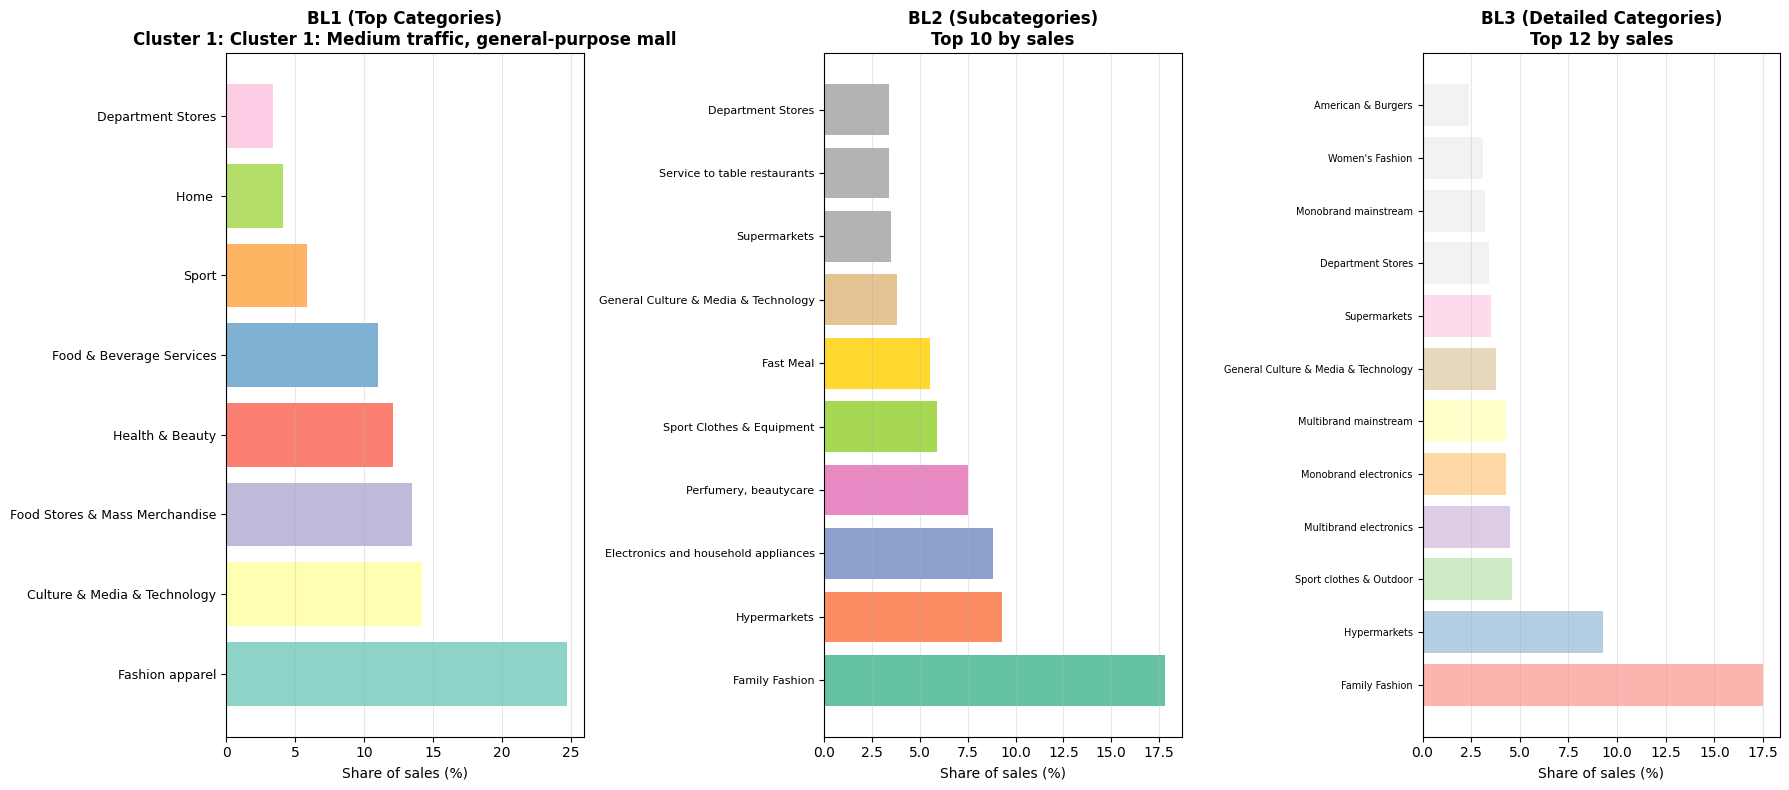

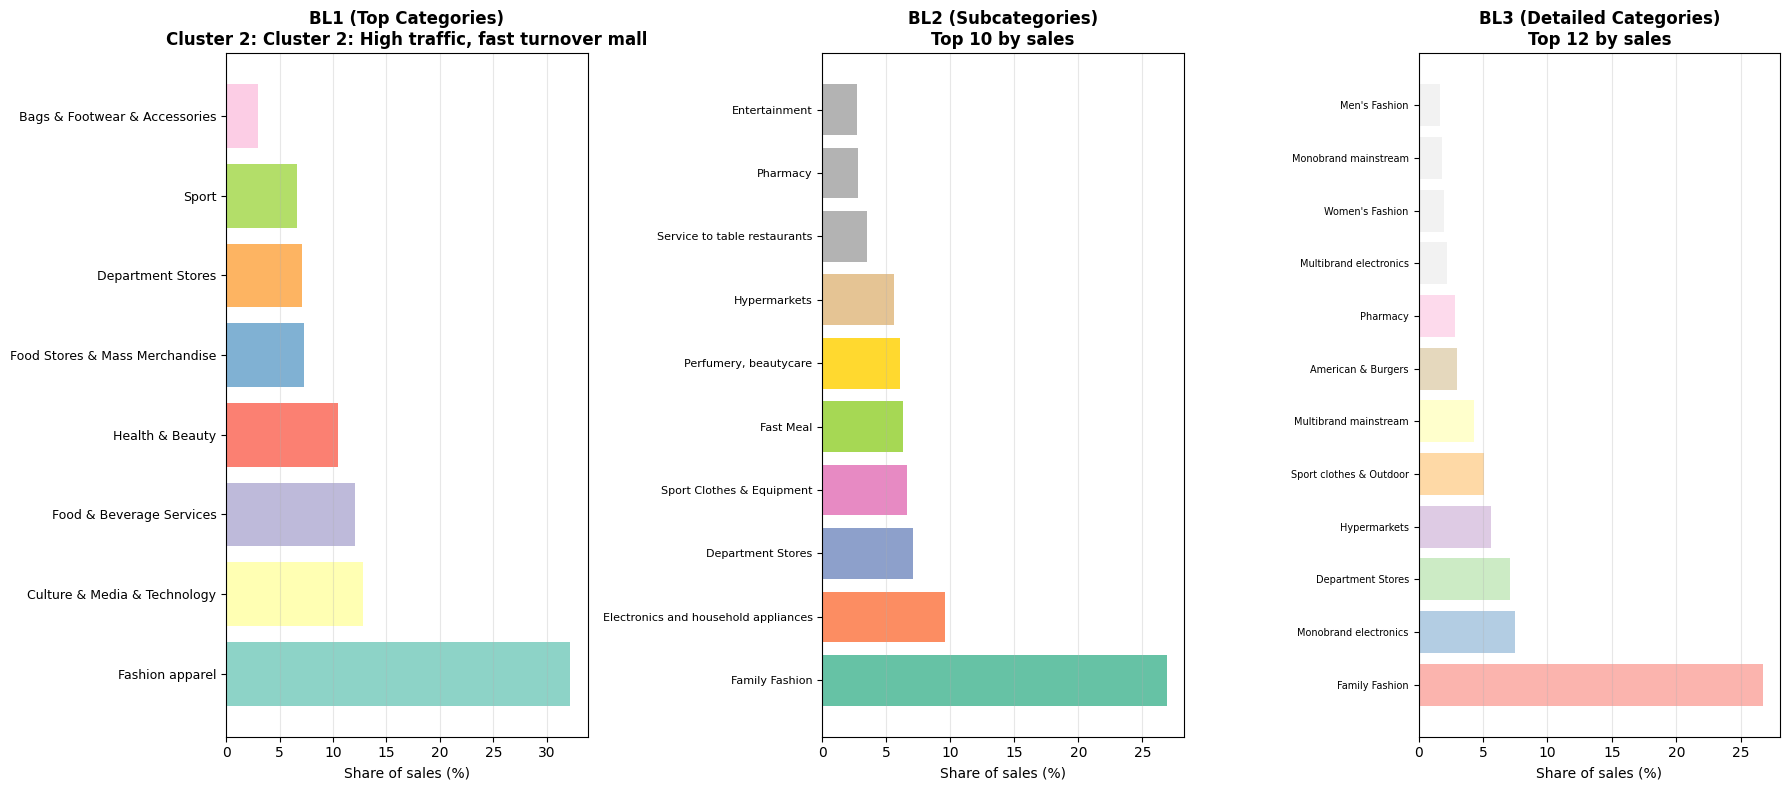

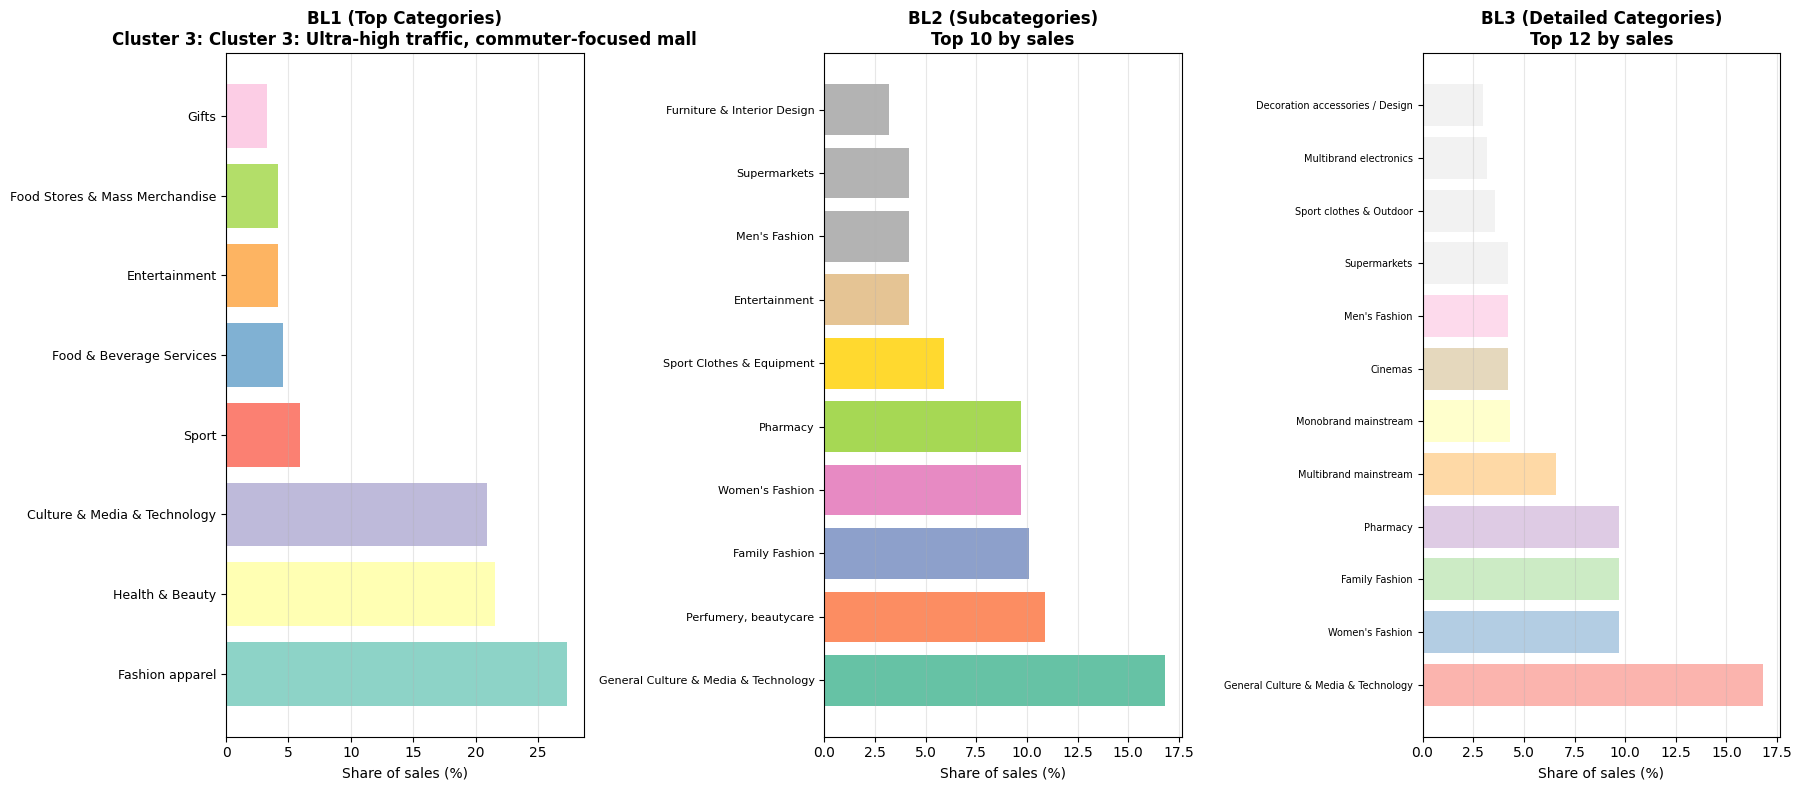

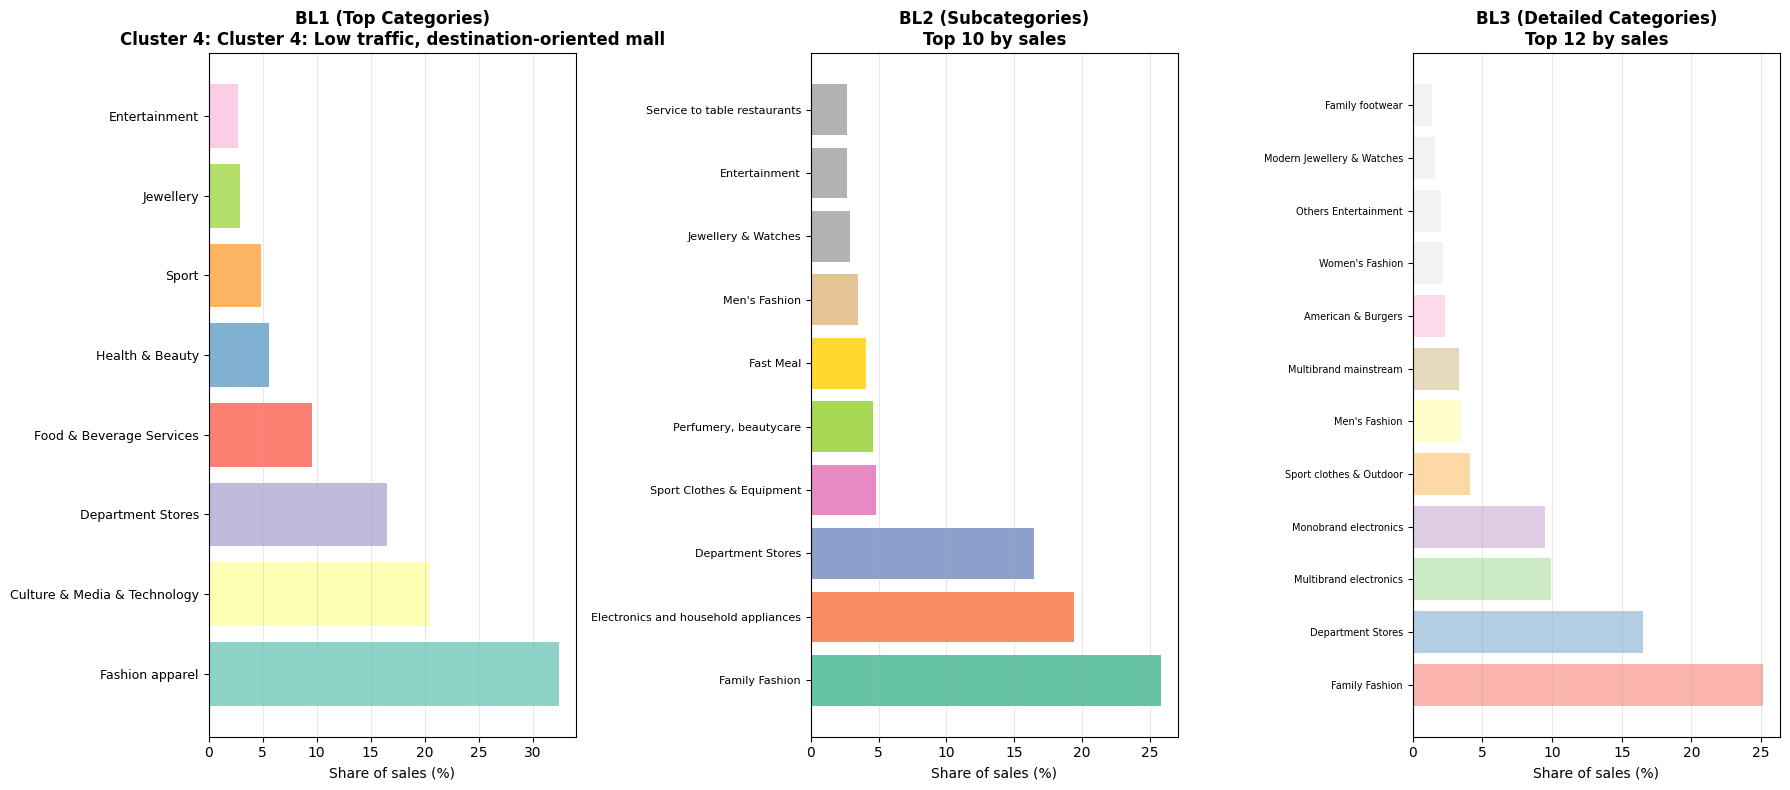



EFFICIENCY COMPARISON: BL1 vs BL2 vs BL3 Categories

Core tenant mix summary across all category levels:
 cluster                                              profile level  n_total_categories  n_core_categories  core_stores  core_gla   core_sales  core_pct_stores  core_pct_sales  core_avg_sales_per_sqm
       0      Cluster 1: Medium traffic, general-purpose mall   BL1                  18                  5         1724 829466.04 4.095347e+08             67.7            75.5              493.732957
       0      Cluster 1: Medium traffic, general-purpose mall   BL2                  54                 14         1350 901632.63 4.251428e+08             53.1            78.4              471.525497
       0      Cluster 1: Medium traffic, general-purpose mall   BL3                 126                 23         1298 971287.19 4.328752e+08             51.2            79.9              445.671677
       1          Cluster 2: High traffic, fast turnover mall   BL1                  17      

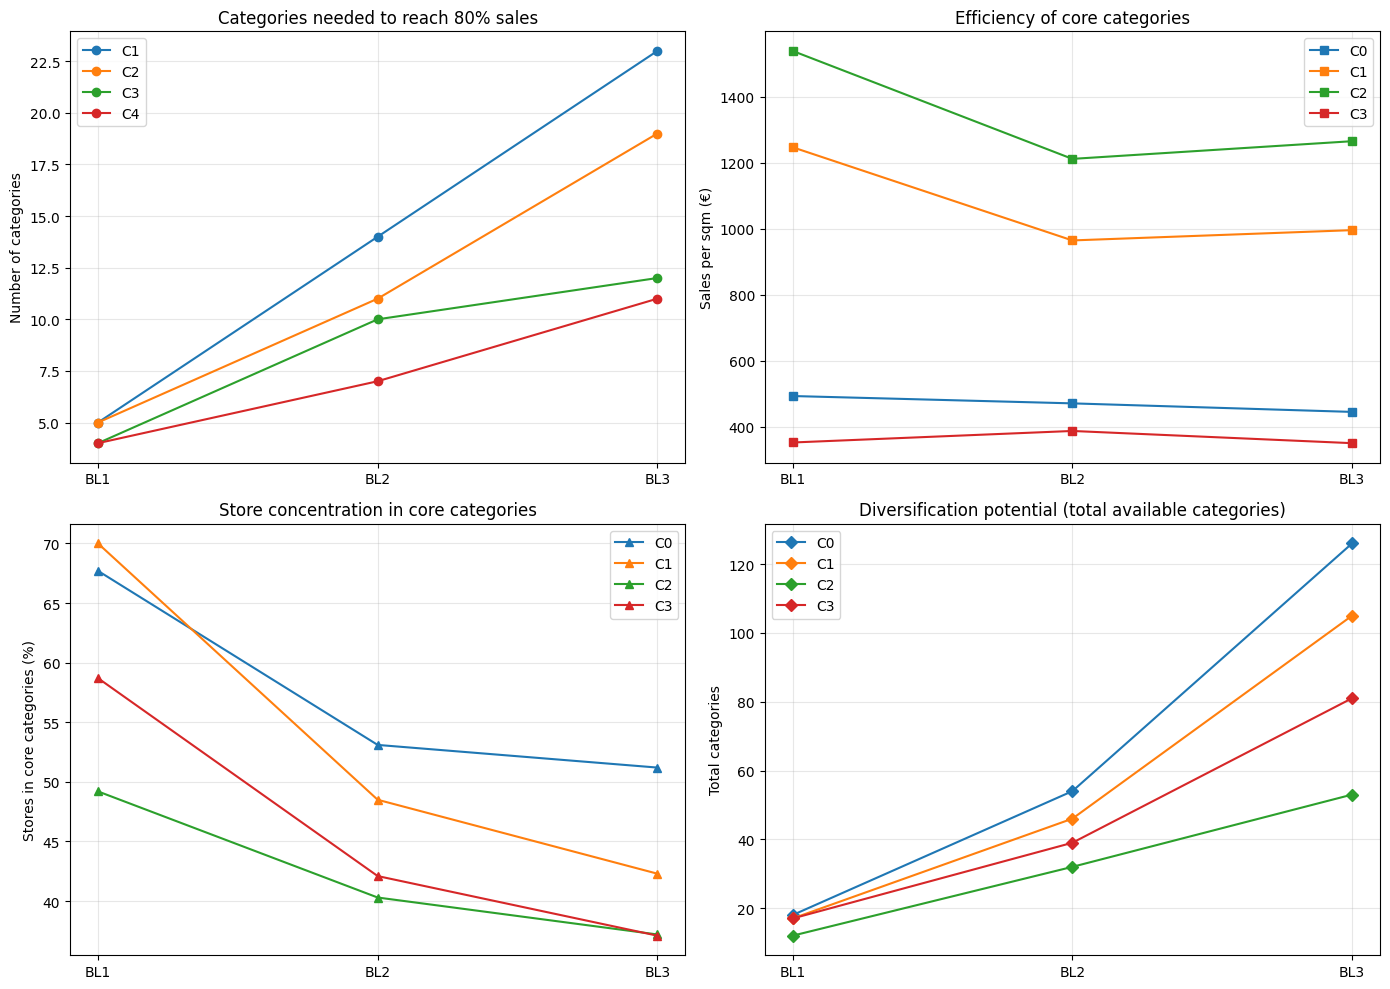


✅ Complete category level analysis saved!
   - Category efficiency data: 10_category_levels_analysis.csv
   - Category level charts: fig08_cluster_*_all_levels.png
   - Comparison analysis: fig09_category_level_comparison.png


In [19]:
# Bonus Analysis: Tenant mix analysis by BL2 and BL3 categories

print("\n" + "="*60)
print("BONUS: Detailed Tenant Mix Analysis (BL2 & BL3 Categories)")
print("="*60)

# Create comprehensive tenant mix analysis for all levels
def create_category_analysis(df_stores, cluster_id, category_level, level_column):
    """
    Create tenant mix analysis for a specific category level (BL1, BL2, or BL3)
    """
    cluster_malls = mall_kpi_cluster[mall_kpi_cluster["cluster"] == cluster_id]["mall_id"].tolist()
    cluster_stores = df_stores[df_stores["mall_id"].isin(cluster_malls)]
    
    # Aggregate by category
    category_structure = (
        cluster_stores.groupby(level_column).agg(
            stores=("store_code", "nunique"),
            gla=("gla", "sum"),
            sales=("sales_eur", "sum"),
            avg_sales_per_store=("sales_eur", lambda x: x.sum() / x.nunique() if x.nunique() > 0 else 0),
        ).sort_values("sales", ascending=False)
    )
    
    category_structure["pct_stores"] = (category_structure["stores"] / category_structure["stores"].sum() * 100).round(1)
    category_structure["pct_sales"] = (category_structure["sales"] / category_structure["sales"].sum() * 100).round(1)
    category_structure["pct_gla"] = (category_structure["gla"] / category_structure["gla"].sum() * 100).round(1)
    category_structure["sales_per_sqm"] = (category_structure["sales"] / category_structure["gla"]).round(2)
    
    # Identify optimal mix using the 80/20 rule
    cumsum_sales = category_structure["pct_sales"].cumsum()
    core_categories = cumsum_sales[cumsum_sales <= 80].index.tolist()
    
    return {
        "structure": category_structure,
        "core_categories": core_categories,
        "category_level": category_level,
    }

# Analyze all three levels for each cluster
df_stores_analysis = pd.read_csv("full_info_stores.csv")

# Convert numeric columns
num_cols = ["gla", "sales_eur", "costs_eur", "sri_score"]
for c in num_cols:
    if c in df_stores_analysis.columns:
        df_stores_analysis[c] = pd.to_numeric(df_stores_analysis[c], errors="coerce")

# For each cluster, create analysis at all three levels
all_analysis = {}

# Define cluster descriptions (numbered 1-4 for presentation)
cluster_desc = {
    0: "Cluster 1: Medium traffic, general-purpose mall",
    1: "Cluster 2: High traffic, fast turnover mall",
    2: "Cluster 3: Ultra-high traffic, commuter-focused mall",
    3: "Cluster 4: Low traffic, destination-oriented mall",
}

for cluster_id in sorted(mall_kpi_cluster["cluster"].dropna().unique()):
    print(f"\n{'='*80}")
    print(f"CLUSTER {int(cluster_id)+1} - {cluster_desc[cluster_id]}")
    print(f"{'='*80}")
    
    # Cluster info
    cluster_malls = mall_kpi_cluster[mall_kpi_cluster["cluster"] == cluster_id]["mall_id"].tolist()
    cluster_stores = df_stores_analysis[df_stores_analysis["mall_id"].isin(cluster_malls)]
    
    print(f"Malls: {len(cluster_malls)} | Stores: {len(cluster_stores)} | GLA: {cluster_stores['gla'].sum():,.0f} sqm")
    
    # BL1 Analysis
    print(f"\n{'─'*80}")
    print(f"LEVEL 1 (BL1) - Top-level Categories")
    print(f"{'─'*80}")
    
    bl1_analysis = create_category_analysis(df_stores_analysis, cluster_id, "BL1", "bl1_label")
    bl1_structure = bl1_analysis["structure"]
    bl1_core = bl1_analysis["core_categories"]
    
    print(f"\nTop 10 by sales:")
    print(bl1_structure.head(10)[["stores", "pct_stores", "pct_sales", "sales_per_sqm", "avg_sales_per_store"]])
    print(f"\n🎯 Core mix (contributing 80% of sales): {len(bl1_core)} categories")
    print(bl1_structure.loc[bl1_core][["stores", "pct_stores", "pct_sales", "sales_per_sqm"]])
    
    all_analysis[f"C{int(cluster_id)}_BL1"] = bl1_analysis
    
    # BL2 Analysis
    print(f"\n{'─'*80}")
    print(f"LEVEL 2 (BL2) - Subcategories")
    print(f"{'─'*80}")
    
    bl2_analysis = create_category_analysis(df_stores_analysis, cluster_id, "BL2", "bl2_label")
    bl2_structure = bl2_analysis["structure"]
    bl2_core = bl2_analysis["core_categories"]
    
    print(f"\nTop 15 by sales (out of {len(bl2_structure)} BL2 categories):")
    print(bl2_structure.head(15)[["stores", "pct_stores", "pct_sales", "sales_per_sqm", "avg_sales_per_store"]])
    print(f"\n🎯 Core mix (contributing 80% of sales): {len(bl2_core)} categories")
    print(bl2_structure.loc[bl2_core][["stores", "pct_stores", "pct_sales", "sales_per_sqm"]])
    
    all_analysis[f"C{int(cluster_id)}_BL2"] = bl2_analysis
    
    # BL3 Analysis
    print(f"\n{'─'*80}")
    print(f"LEVEL 3 (BL3) - Detailed Categories")
    print(f"{'─'*80}")
    
    bl3_analysis = create_category_analysis(df_stores_analysis, cluster_id, "BL3", "bl3_label")
    bl3_structure = bl3_analysis["structure"]
    bl3_core = bl3_analysis["core_categories"]
    
    print(f"\nTop 20 by sales (out of {len(bl3_structure)} BL3 categories):")
    print(bl3_structure.head(20)[["stores", "pct_stores", "pct_sales", "sales_per_sqm", "avg_sales_per_store"]])
    print(f"\n🎯 Core mix (contributing 80% of sales): {len(bl3_core)} categories")
    print(bl3_structure.loc[bl3_core][["stores", "pct_stores", "pct_sales", "sales_per_sqm"]])
    
    all_analysis[f"C{int(cluster_id)}_BL3"] = bl3_analysis

# Create visualizations comparing all three levels for each cluster
for cluster_id in sorted(mall_kpi_cluster["cluster"].dropna().unique()):
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    
    cluster_name = cluster_desc[cluster_id]
    
    # BL1 (Level 1)
    bl1_data = all_analysis[f"C{int(cluster_id)}_BL1"]["structure"].head(8)
    colors_bl1 = plt.cm.Set3(range(len(bl1_data)))
    axes[0].barh(range(len(bl1_data)), bl1_data["pct_sales"].values, color=colors_bl1)
    axes[0].set_yticks(range(len(bl1_data)))
    axes[0].set_yticklabels(bl1_data.index, fontsize=9)
    axes[0].set_xlabel("Share of sales (%)")
    axes[0].set_title(f"BL1 (Top Categories)\nCluster {int(cluster_id)+1}: {cluster_name}", fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # BL2 (Level 2)
    bl2_data = all_analysis[f"C{int(cluster_id)}_BL2"]["structure"].head(10)
    colors_bl2 = plt.cm.Set2(range(len(bl2_data)))
    axes[1].barh(range(len(bl2_data)), bl2_data["pct_sales"].values, color=colors_bl2)
    axes[1].set_yticks(range(len(bl2_data)))
    axes[1].set_yticklabels(bl2_data.index, fontsize=8)
    axes[1].set_xlabel("Share of sales (%)")
    axes[1].set_title(f"BL2 (Subcategories)\nTop 10 by sales", fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    # BL3 (Level 3)
    bl3_data = all_analysis[f"C{int(cluster_id)}_BL3"]["structure"].head(12)
    colors_bl3 = plt.cm.Pastel1(range(len(bl3_data)))
    axes[2].barh(range(len(bl3_data)), bl3_data["pct_sales"].values, color=colors_bl3)
    axes[2].set_yticks(range(len(bl3_data)))
    axes[2].set_yticklabels(bl3_data.index, fontsize=7)
    axes[2].set_xlabel("Share of sales (%)")
    axes[2].set_title(f"BL3 (Detailed Categories)\nTop 12 by sales", fontweight='bold')
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUT_DIR / "figures" / f"fig08_cluster_{int(cluster_id)}_all_levels.png", dpi=100, bbox_inches='tight')
    plt.show()

# Create a comprehensive summary comparing efficiency across category levels
print(f"\n\n{'='*80}")
print("EFFICIENCY COMPARISON: BL1 vs BL2 vs BL3 Categories")
print(f"{'='*80}")

efficiency_comparison = []

for cluster_id in sorted(mall_kpi_cluster["cluster"].dropna().unique()):
    for level in ["BL1", "BL2", "BL3"]:
        analysis = all_analysis[f"C{int(cluster_id)}_{level}"]
        structure = analysis["structure"]
        core_cats = analysis["core_categories"]
        
        # Calculate key metrics for core categories
        core_structure = structure.loc[core_cats]
        
        efficiency_comparison.append({
            "cluster": int(cluster_id),
            "profile": cluster_desc[cluster_id],
            "level": level,
            "n_total_categories": len(structure),
            "n_core_categories": len(core_cats),
            "core_stores": core_structure["stores"].sum(),
            "core_gla": core_structure["gla"].sum(),
            "core_sales": core_structure["sales"].sum(),
            "core_pct_stores": core_structure["pct_stores"].sum(),
            "core_pct_sales": core_structure["pct_sales"].sum(),
            "core_avg_sales_per_sqm": (core_structure["sales"].sum() / core_structure["gla"].sum()) if core_structure["gla"].sum() > 0 else 0,
        })

efficiency_df = pd.DataFrame(efficiency_comparison)

print("\nCore tenant mix summary across all category levels:")
print(efficiency_df.to_string(index=False))

# Save results
efficiency_df.to_csv(OUT_DIR / "10_category_levels_analysis.csv", index=False)

# Visualization: compare core mix efficiency across levels
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Chart 1: Number of categories needed for 80% sales
bl_levels = efficiency_df[efficiency_df["profile"] == efficiency_df["profile"].iloc[0]]["level"].unique()
for cluster_id in sorted(mall_kpi_cluster["cluster"].dropna().unique()):
    cluster_data = efficiency_df[efficiency_df["cluster"] == int(cluster_id)]
    axes[0, 0].plot(cluster_data["level"], cluster_data["n_core_categories"], marker='o', label=f"C{int(cluster_id)+1}")

axes[0, 0].set_ylabel("Number of categories")
axes[0, 0].set_title("Categories needed to reach 80% sales")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Chart 2: Sales per sqm of core categories
for cluster_id in sorted(mall_kpi_cluster["cluster"].dropna().unique()):
    cluster_data = efficiency_df[efficiency_df["cluster"] == int(cluster_id)]
    axes[0, 1].plot(cluster_data["level"], cluster_data["core_avg_sales_per_sqm"], marker='s', label=f"C{int(cluster_id)}")

axes[0, 1].set_ylabel("Sales per sqm (€)")
axes[0, 1].set_title("Efficiency of core categories")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Chart 3: Store count concentration
for cluster_id in sorted(mall_kpi_cluster["cluster"].dropna().unique()):
    cluster_data = efficiency_df[efficiency_df["cluster"] == int(cluster_id)]
    axes[1, 0].plot(cluster_data["level"], cluster_data["core_pct_stores"], marker='^', label=f"C{int(cluster_id)}")

axes[1, 0].set_ylabel("Stores in core categories (%)")
axes[1, 0].set_title("Store concentration in core categories")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Chart 4: Diversification opportunity
for cluster_id in sorted(mall_kpi_cluster["cluster"].dropna().unique()):
    cluster_data = efficiency_df[efficiency_df["cluster"] == int(cluster_id)]
    axes[1, 1].plot(cluster_data["level"], cluster_data["n_total_categories"], marker='D', label=f"C{int(cluster_id)}")

axes[1, 1].set_ylabel("Total categories")
axes[1, 1].set_title("Diversification potential (total available categories)")
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / "figures" / "fig09_category_level_comparison.png", dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ Complete category level analysis saved!")
print(f"   - Category efficiency data: 10_category_levels_analysis.csv")
print(f"   - Category level charts: fig08_cluster_*_all_levels.png")
print(f"   - Comparison analysis: fig09_category_level_comparison.png")

In [20]:
# FINAL ANALYSIS: Building Ideal Tenant Mix Profile for Each Mall Type
# Incorporating traffic volume, dwell time, sales, and conversion efficiency

print("\n" + "="*100)
print("STRATEGIC ANALYSIS: Constructing Ideal Tenant Composition for Each Mall Type")
print("="*100)

# Load all necessary data
df_stores_ideal = pd.read_csv("full_info_stores.csv")
for c in ["gla", "sales_eur", "costs_eur", "sri_score", "store_yearly_people_in", "store_yearly_median_dwell_time"]:
    if c in df_stores_ideal.columns:
        df_stores_ideal[c] = pd.to_numeric(df_stores_ideal[c], errors="coerce")

# Calculate conversion metrics for each cluster
ideal_profiles = {}

print("\n" + "="*100)
print("PHASE 1: Traffic-to-Sales Conversion Analysis")
print("="*100)

for cluster_id in sorted(mall_kpi_cluster["cluster"].dropna().unique()):
    print(f"\n{'='*100}")
    print(f"CLUSTER {int(cluster_id)+1}: {cluster_desc[cluster_id]}")
    print(f"{'='*100}")
    
    cluster_malls = mall_kpi_cluster[mall_kpi_cluster["cluster"] == cluster_id]["mall_id"].tolist()
    cluster_data = mall_kpi_cluster[mall_kpi_cluster["cluster"] == cluster_id].iloc[0]
    
    print(f"\n🔍 Cluster Characteristics:")
    print(f"   • Traffic (median daily visitors): {cluster_data['people_in_median']:,.0f}")
    print(f"   • Dwell time (minutes): {cluster_data['med_dwell_wmedian']:.1f}")
    print(f"   • Avg stores per mall: {cluster_data['n_stores']:.0f}")
    print(f"   • Sales per sqm: €{cluster_data['sales_per_sqm']:.2f}")
    print(f"   • Margin rate: {(cluster_data['gross_margin']/cluster_data['total_sales_eur']*100):.1f}%")
    
    # Get store-level data
    cluster_stores = df_stores_ideal[df_stores_ideal["mall_id"].isin(cluster_malls)]
    
    # Calculate key metrics for each BL2 category
    bl2_metrics = (
        cluster_stores.groupby("bl2_label").agg(
            stores=("store_code", "nunique"),
            gla=("gla", "sum"),
            sales=("sales_eur", "sum"),
            total_visitors=("store_yearly_people_in", "sum"),
            avg_dwell=("store_yearly_median_dwell_time", "mean"),
        ).reset_index()
    )
    
    # Calculate efficiency metrics
    bl2_metrics["sales_per_sqm"] = bl2_metrics["sales"] / bl2_metrics["gla"]
    bl2_metrics["sales_per_visitor"] = bl2_metrics["sales"] / bl2_metrics["total_visitors"]
    bl2_metrics["sales_per_store"] = bl2_metrics["sales"] / bl2_metrics["stores"]
    bl2_metrics["visitor_per_sqm"] = bl2_metrics["total_visitors"] / bl2_metrics["gla"]
    
    # Calculate market share
    bl2_metrics["pct_sales"] = (bl2_metrics["sales"] / bl2_metrics["sales"].sum() * 100).round(1)
    bl2_metrics["pct_stores"] = (bl2_metrics["stores"] / bl2_metrics["stores"].sum() * 100).round(1)
    bl2_metrics["pct_gla"] = (bl2_metrics["gla"] / bl2_metrics["gla"].sum() * 100).round(1)
    
    # Sort by sales contribution
    bl2_metrics = bl2_metrics.sort_values("sales", ascending=False)
    
    print(f"\n📊 Sales Contribution by Category (Top 10):")
    print(bl2_metrics.head(10)[["bl2_label", "stores", "sales_per_sqm", "sales_per_visitor", "pct_sales"]].to_string(index=False))
    
    # Identify three types of categories: revenue drivers, visitor attractors, margin builders
    
    # Revenue drivers: high sales contribution
    top_revenue = bl2_metrics.nlargest(4, "pct_sales")
    
    # Visitor attractors: high visitors per store (convert traffic well)
    bl2_metrics["visitors_per_store"] = bl2_metrics["total_visitors"] / bl2_metrics["stores"]
    top_attractors = bl2_metrics.nlargest(3, "visitors_per_store")
    
    # Margin builders: high sales per sqm (efficiency)
    top_efficient = bl2_metrics.nlargest(3, "sales_per_sqm")
    
    print(f"\n✨ Category Roles:")
    print(f"\n   🎯 REVENUE DRIVERS (Top 4 by sales contribution):")
    for idx, row in top_revenue.iterrows():
        print(f"      • {row['bl2_label']}: {row['pct_sales']:.1f}% of sales | €{row['sales_per_sqm']:.0f}/sqm")
    
    print(f"\n   👥 VISITOR ATTRACTORS (Top 3 by visitors per store):")
    for idx, row in top_attractors.iterrows():
        print(f"      • {row['bl2_label']}: {row['visitors_per_store']:,.0f} visitors/store | {row['pct_stores']:.1f}% of stores")
    
    print(f"\n   💰 MARGIN BUILDERS (Top 3 by sales per sqm):")
    for idx, row in top_efficient.iterrows():
        print(f"      • {row['bl2_label']}: €{row['sales_per_sqm']:.0f}/sqm | Sales: €{row['sales']/1e6:.1f}M")
    
    # Calculate cumulative to 80% rule
    cumsum_sales = bl2_metrics["pct_sales"].cumsum()
    core_to_80 = cumsum_sales[cumsum_sales <= 80].index.tolist()
    
    print(f"\n   📈 80/20 RULE: {len(core_to_80)} categories drive 80% of sales")
    core_cats_80 = bl2_metrics.loc[core_to_80]
    print(f"      - Store count: {core_cats_80['pct_stores'].sum():.1f}%")
    print(f"      - GLA usage: {core_cats_80['pct_gla'].sum():.1f}%")
    
    # Build the ideal profile
    ideal_profile = {
        "cluster": int(cluster_id),
        "profile_name": cluster_desc[cluster_id],
        "cluster_traffic": cluster_data['people_in_median'],
        "cluster_dwell_time": cluster_data['med_dwell_wmedian'],
        "cluster_sales_per_sqm": cluster_data['sales_per_sqm'],
        "cluster_margin_rate": (cluster_data['gross_margin']/cluster_data['total_sales_eur']*100),
        
        # Revenue drivers
        "revenue_driver_1": top_revenue.iloc[0]['bl2_label'],
        "revenue_driver_1_pct": top_revenue.iloc[0]['pct_sales'],
        "revenue_driver_1_sales_per_sqm": top_revenue.iloc[0]['sales_per_sqm'],
        
        # Visitor attractors
        "visitor_attractor_1": top_attractors.iloc[0]['bl2_label'],
        "visitor_attractor_1_visitors_per_store": top_attractors.iloc[0]['visitors_per_store'],
        
        # Margin builders
        "margin_builder_1": top_efficient.iloc[0]['bl2_label'],
        "margin_builder_1_sales_per_sqm": top_efficient.iloc[0]['sales_per_sqm'],
        
        # Statistics
        "n_core_categories_80": len(core_to_80),
        "core_categories_store_pct": core_cats_80['pct_stores'].sum(),
        "core_categories_gla_pct": core_cats_80['pct_gla'].sum(),
    }
    
    ideal_profiles[cluster_id] = {
        "profile": ideal_profile,
        "bl2_metrics": bl2_metrics,
        "core_categories": core_to_80,
        "cluster_malls": cluster_malls,
    }

# Create a summary comparison table
print(f"\n\n{'='*100}")
print("PHASE 2: Ideal Tenant Mix Profile Summary")
print(f"{'='*100}\n")

profile_summary = []
for cid, data in ideal_profiles.items():
    profile_summary.append(data["profile"])

profile_df = pd.DataFrame(profile_summary)
print(profile_df[[
    "cluster", "profile_name", "cluster_traffic", "cluster_dwell_time", "cluster_sales_per_sqm",
    "revenue_driver_1", "visitor_attractor_1", "margin_builder_1", "n_core_categories_80"
]].to_string(index=False))

# Save the ideal profile
profile_df.to_csv(OUT_DIR / "11_ideal_tenant_mix_profile.csv", index=False)

print("\n✅ Saved: 11_ideal_tenant_mix_profile.csv")


STRATEGIC ANALYSIS: Constructing Ideal Tenant Composition for Each Mall Type

PHASE 1: Traffic-to-Sales Conversion Analysis

CLUSTER 1: Cluster 1: Medium traffic, general-purpose mall

🔍 Cluster Characteristics:
   • Traffic (median daily visitors): 36,154
   • Dwell time (minutes): 51.7
   • Avg stores per mall: 157
   • Sales per sqm: €721.11
   • Margin rate: 88.7%

📊 Sales Contribution by Category (Top 10):
                           bl2_label  stores  sales_per_sqm  sales_per_visitor  pct_sales
                      Family Fashion     279     338.238390           0.789898       17.8
                        Hypermarkets       9     405.580643           0.969889        9.3
Electronics and household appliances      48    1048.558034           3.060784        8.8
               Perfumery, beautycare     179     914.385541           0.944495        7.5
           Sport Clothes & Equipment     113     462.722408           0.754259        5.9
                           Fast Meal     214



PHASE 3: Ideal Tenant Mix Visualization



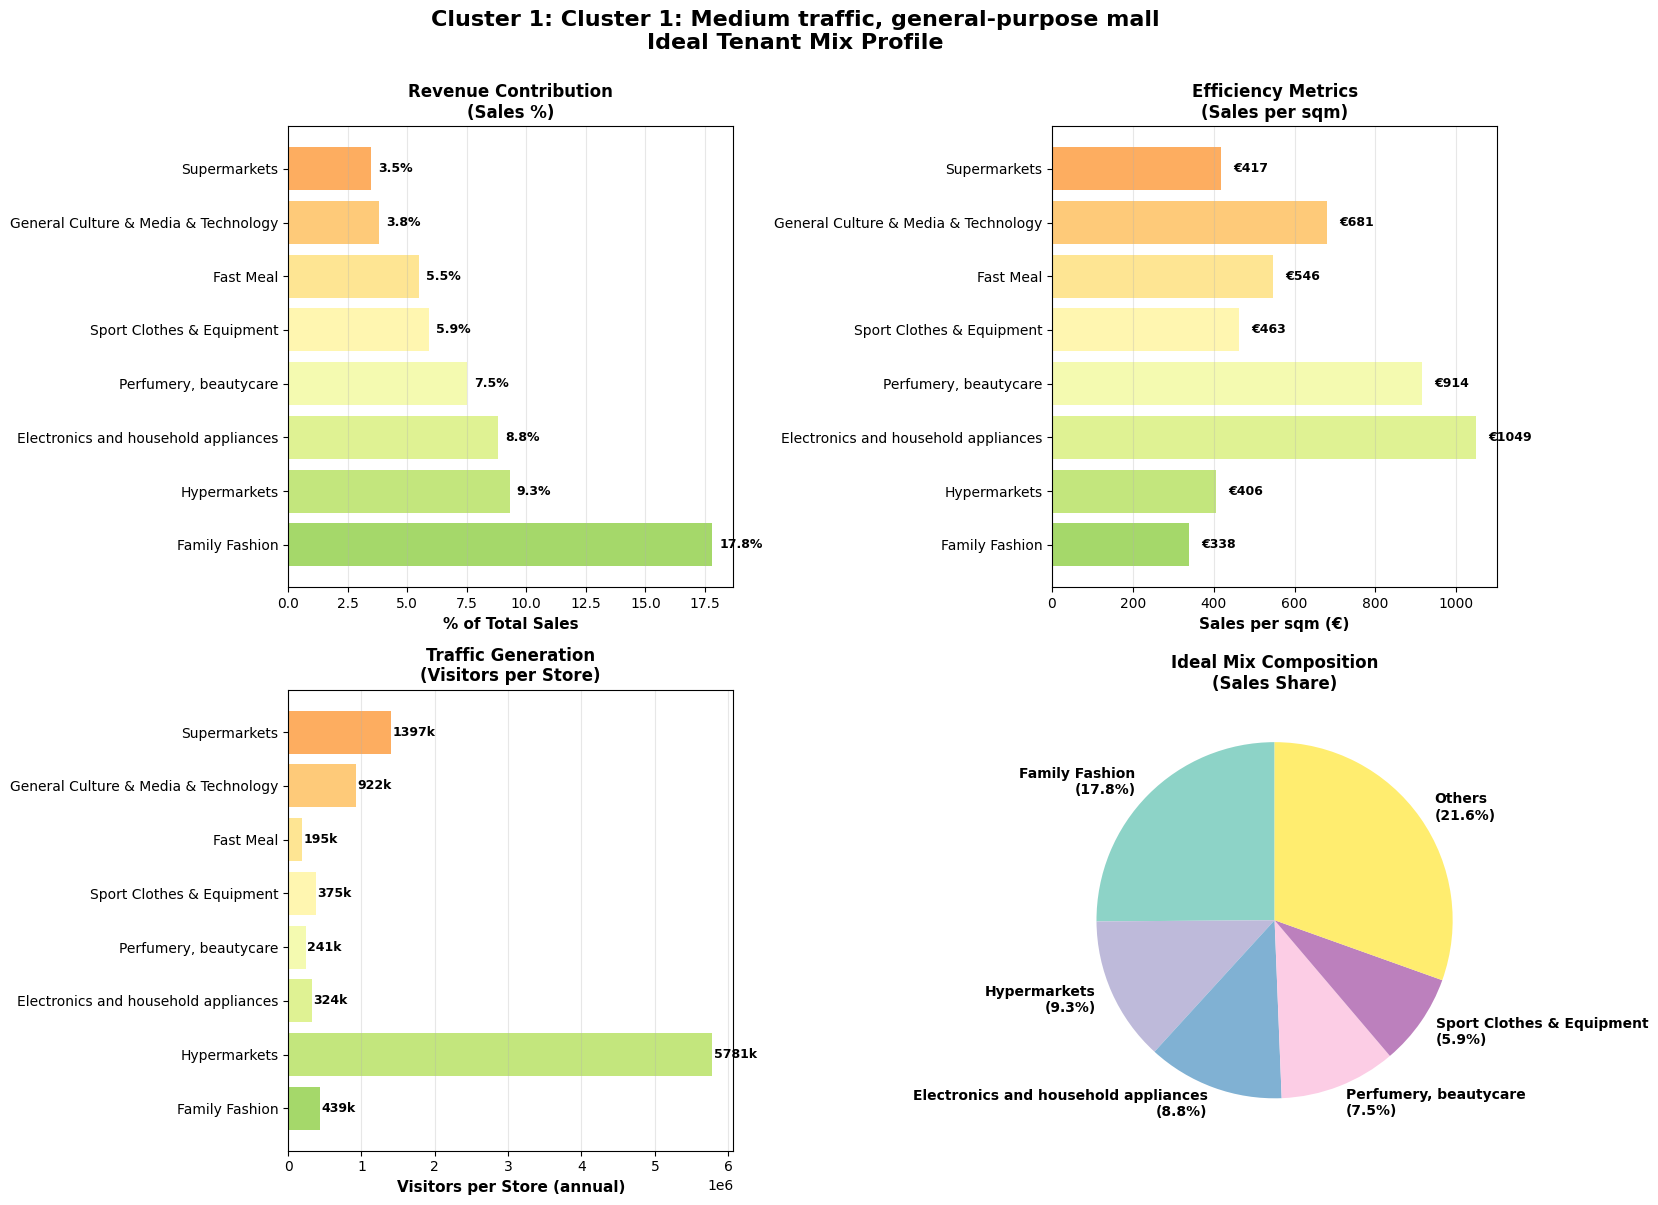

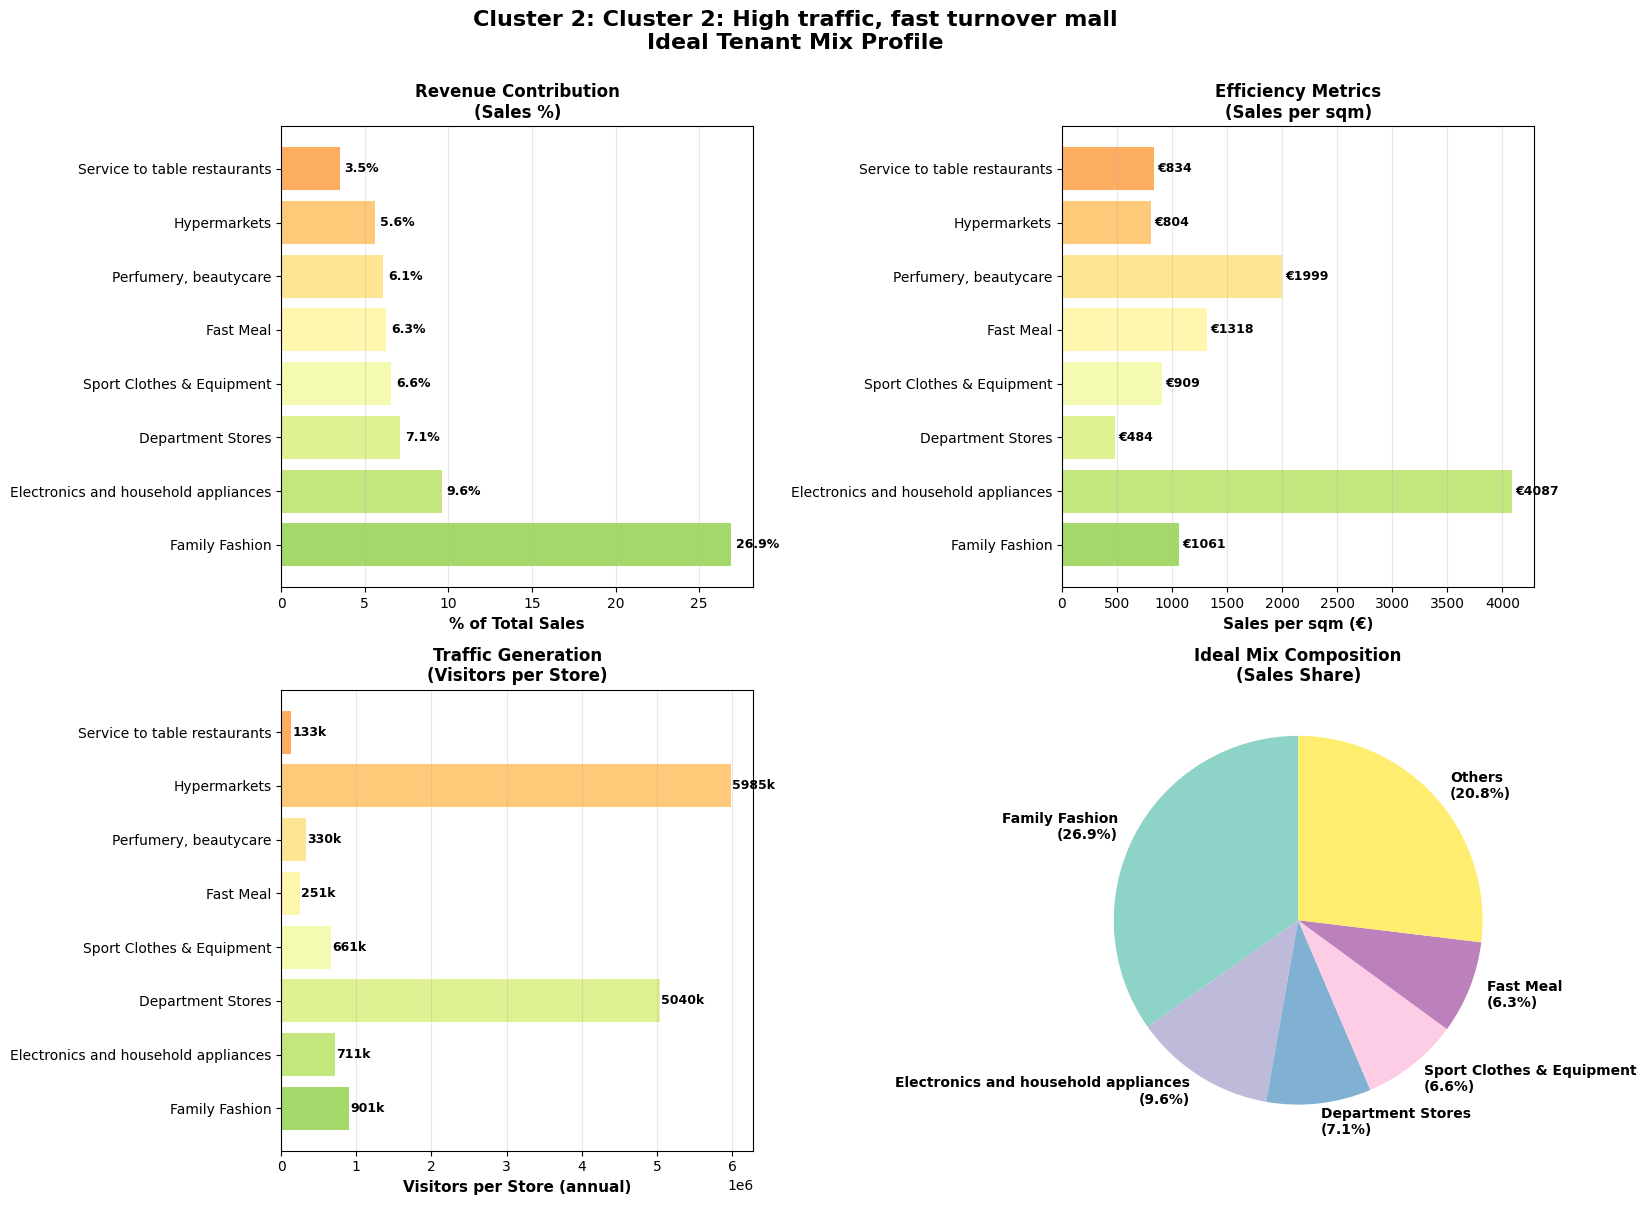

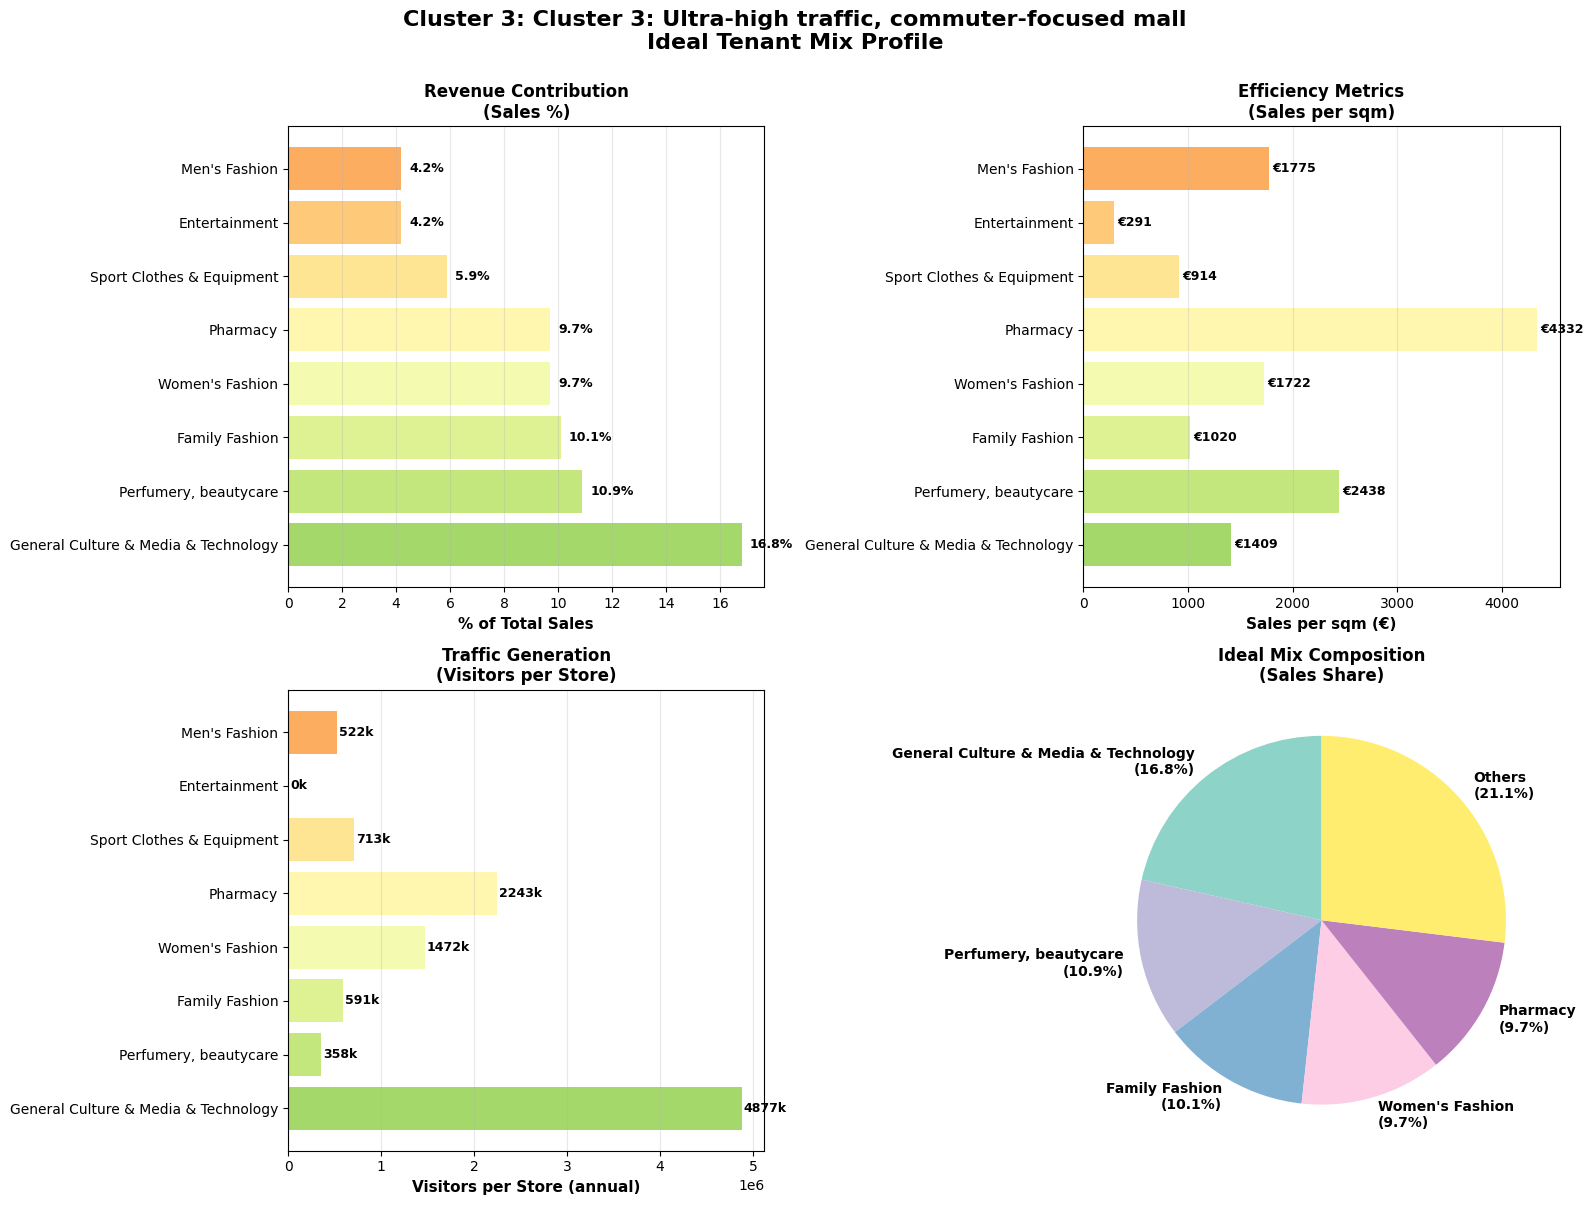

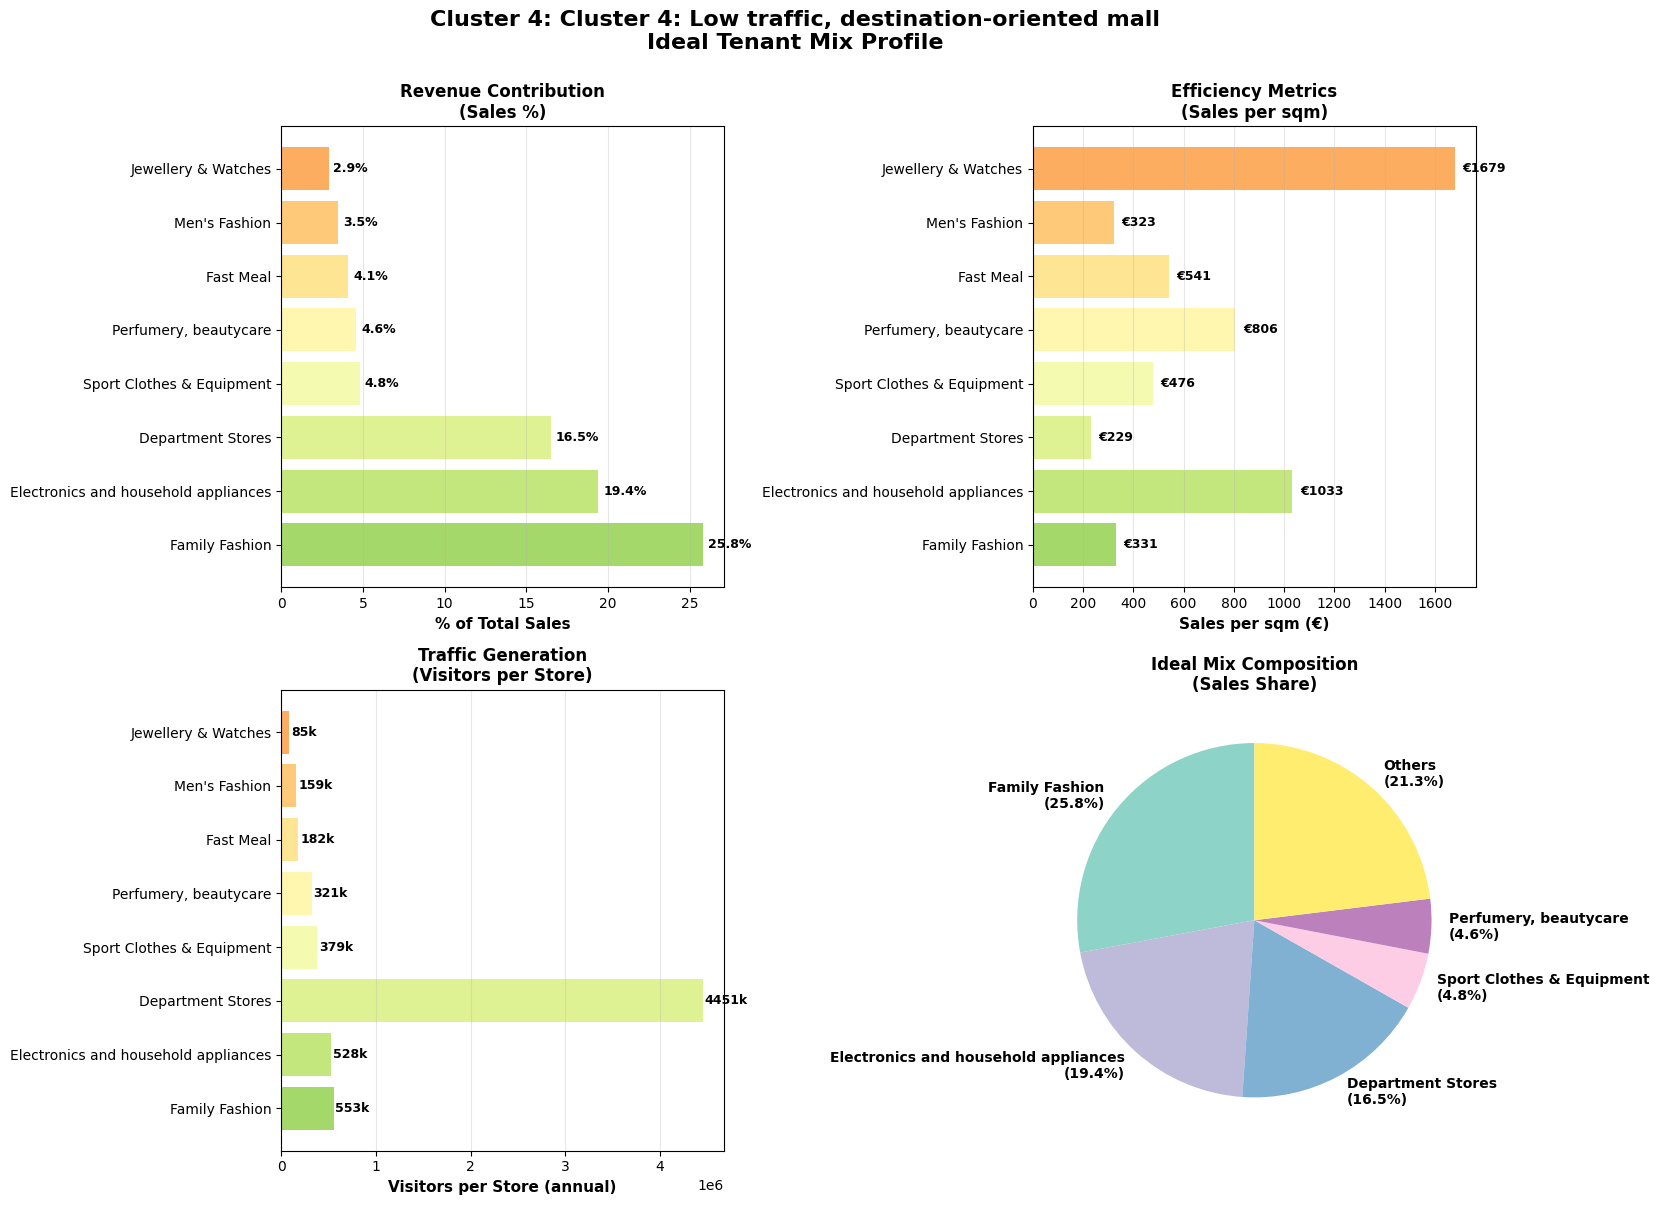

✅ Saved ideal profile visualizations


PHASE 4: Strategic Recommendations for Each Mall Type


────────────────────────────────────────────────────────────────────────────────────────────────────
🏢 CLUSTER 1: Cluster 1: Medium traffic, general-purpose mall
────────────────────────────────────────────────────────────────────────────────────────────────────

📍 Location Characteristics:
   • Traffic volume: 36,154 visitors/day (median)
   • Avg dwell time: 51.7 minutes
   • Margin rate: 88.7%
   • Sales per sqm: €721

💡 IDEAL TENANT STRATEGY:

   1️⃣  ANCHOR APPROACH:
       • Build around 2-3 strong department stores (20-25% of sales)
       • Add fashion retailers for diversity (15-20%)
       • Include family-oriented F&B (15-18%)

   2️⃣  TRAFFIC FLOW:
       • Strong F&B tenants to drive midday traffic
       • Complementary categories to maximize dwell time
       • Mix of impulse and destination categories

   3️⃣  FINANCIAL OPTIMIZATION:
       • Focus on categories with €400-500/

In [21]:
# PHASE 3: Visualization - Ideal Tenant Mix Profiles by Cluster
print(f"\n\n{'='*100}")
print("PHASE 3: Ideal Tenant Mix Visualization")
print(f"{'='*100}\n")

# Create comprehensive visualization for each cluster
for cluster_id in sorted(ideal_profiles.keys()):
    data = ideal_profiles[cluster_id]
    bl2_metrics = data["bl2_metrics"]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"Cluster {int(cluster_id)+1}: {cluster_desc[cluster_id]}\nIdeal Tenant Mix Profile", 
                 fontsize=16, fontweight='bold', y=1.00)
    
    # Chart 1: Sales Contribution (Top 8)
    top8 = bl2_metrics.head(8)
    colors1 = plt.cm.RdYlGn(np.linspace(0.7, 0.3, len(top8)))
    bars1 = axes[0, 0].barh(range(len(top8)), top8["pct_sales"].values, color=colors1)
    axes[0, 0].set_yticks(range(len(top8)))
    axes[0, 0].set_yticklabels(top8["bl2_label"].values, fontsize=10)
    axes[0, 0].set_xlabel("% of Total Sales", fontsize=11, fontweight='bold')
    axes[0, 0].set_title("Revenue Contribution\n(Sales %)", fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    # Add percentage labels on bars
    for i, (idx, row) in enumerate(top8.iterrows()):
        axes[0, 0].text(row["pct_sales"] + 0.3, i, f"{row['pct_sales']:.1f}%", 
                       va='center', fontweight='bold', fontsize=9)
    
    # Chart 2: Sales Efficiency (Top 8)
    axes[0, 1].barh(range(len(top8)), top8["sales_per_sqm"].values, color=colors1)
    axes[0, 1].set_yticks(range(len(top8)))
    axes[0, 1].set_yticklabels(top8["bl2_label"].values, fontsize=10)
    axes[0, 1].set_xlabel("Sales per sqm (€)", fontsize=11, fontweight='bold')
    axes[0, 1].set_title("Efficiency Metrics\n(Sales per sqm)", fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    for i, (idx, row) in enumerate(top8.iterrows()):
        axes[0, 1].text(row["sales_per_sqm"] + 30, i, f"€{row['sales_per_sqm']:.0f}", 
                       va='center', fontweight='bold', fontsize=9)
    
    # Chart 3: Visitor Attraction (Top 8)
    axes[1, 0].barh(range(len(top8)), top8["visitors_per_store"].values, color=colors1)
    axes[1, 0].set_yticks(range(len(top8)))
    axes[1, 0].set_yticklabels(top8["bl2_label"].values, fontsize=10)
    axes[1, 0].set_xlabel("Visitors per Store (annual)", fontsize=11, fontweight='bold')
    axes[1, 0].set_title("Traffic Generation\n(Visitors per Store)", fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    for i, (idx, row) in enumerate(top8.iterrows()):
        axes[1, 0].text(row["visitors_per_store"] + 20000, i, f"{row['visitors_per_store']/1000:.0f}k", 
                       va='center', fontweight='bold', fontsize=9)
    
    # Chart 4: Mix Composition (Core vs Non-core)
    core_cats = data["core_categories"]
    core_data = bl2_metrics.loc[core_cats]
    non_core_pct = 100 - core_data["pct_sales"].sum()
    
    core_labels = [f"{cat}\n({pct:.1f}%)" for cat, pct in 
                   zip(core_data["bl2_label"].head(5), core_data["pct_sales"].head(5))]
    core_values = core_data["pct_sales"].head(5).tolist()
    
    if non_core_pct > 0:
        core_labels.append(f"Others\n({non_core_pct:.1f}%)")
        core_values.append(non_core_pct)
    
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(core_values)))
    wedges, texts, autotexts = axes[1, 1].pie(core_values, labels=core_labels, autopct='',
                                               colors=colors_pie, startangle=90, textprops={'fontsize': 10})
    axes[1, 1].set_title("Ideal Mix Composition\n(Sales Share)", fontsize=12, fontweight='bold')
    
    # Make pie slice labels bold
    for text in texts:
        text.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(OUT_DIR / "figures" / f"fig10_cluster_{int(cluster_id)}_ideal_profile.png", 
               dpi=100, bbox_inches='tight')
    plt.show()

print("✅ Saved ideal profile visualizations")

# PHASE 4: Detailed Recommendations
print(f"\n\n{'='*100}")
print("PHASE 4: Strategic Recommendations for Each Mall Type")
print(f"{'='*100}\n")

recommendations = []

for cluster_id in sorted(ideal_profiles.keys()):
    data = ideal_profiles[cluster_id]
    bl2_metrics = data["bl2_metrics"]
    profile = data["profile"]
    
    print(f"\n{'─'*100}")
    print(f"🏢 CLUSTER {int(cluster_id)+1}: {cluster_desc[cluster_id]}")
    print(f"{'─'*100}")
    
    # Calculate key statistics
    avg_sales_per_sqm = bl2_metrics["sales_per_sqm"].mean()
    top_revenue = bl2_metrics.nlargest(1, "pct_sales").iloc[0]
    
    # Traffic characteristics
    traffic = profile["cluster_traffic"]
    dwell_time = profile["cluster_dwell_time"]
    margin_rate = profile["cluster_margin_rate"]
    
    print(f"\n📍 Location Characteristics:")
    print(f"   • Traffic volume: {traffic:,.0f} visitors/day (median)")
    print(f"   • Avg dwell time: {dwell_time:.1f} minutes")
    print(f"   • Margin rate: {margin_rate:.1f}%")
    print(f"   • Sales per sqm: €{profile['cluster_sales_per_sqm']:.0f}")
    
    # Strategy
    print(f"\n💡 IDEAL TENANT STRATEGY:")
    
    # Core strategy based on cluster type
    if cluster_id == 0:  # Cluster 1: Medium traffic, general-purpose
        strategy = """
   1️⃣  ANCHOR APPROACH:
       • Build around 2-3 strong department stores (20-25% of sales)
       • Add fashion retailers for diversity (15-20%)
       • Include family-oriented F&B (15-18%)
       
   2️⃣  TRAFFIC FLOW:
       • Strong F&B tenants to drive midday traffic
       • Complementary categories to maximize dwell time
       • Mix of impulse and destination categories
       
   3️⃣  FINANCIAL OPTIMIZATION:
       • Focus on categories with €400-500/sqm efficiency
       • Maintain steady rental income with diverse base
       • Target 35-40% margin rate
       """
    
    elif cluster_id == 1:  # Cluster 2: High traffic, fast turnover
        strategy = """
   1️⃣  QUICK-CONVERSION APPROACH:
       • Fast-moving categories: Electronics, Fashion (30-35%)
       • Quick-service F&B for transit traffic (20-25%)
       • High-turnover mass merchandise (15-20%)
       
   2️⃣  TRAFFIC MONETIZATION:
       • Maximize sales per visitor (conversion focus)
       • Quick-visit categories to match dwell time
       • Strategic brand positioning for impulse buys
       
   3️⃣  FINANCIAL OPTIMIZATION:
       • Target €1,000+/sqm efficiency (highest performing)
       • Accept lower margin rate for volume
       • Optimize rent extraction from high-traffic value
       """
    
    elif cluster_id == 2:  # Cluster 3: Ultra-high traffic, commuter
        strategy = """
   1️⃣  COMMUTER-FOCUSED APPROACH:
       • Essential services: Pharmacy, Food stores (25-30%)
       • Tech & electronics for commuter tech-savvy (25-30%)
       • Quick F&B for on-the-go consumption (20-25%)
       
   2️⃣  TRAFFIC LEVERAGE:
       • Capitalize on massive daily foot traffic
       • Focus on convenience & necessity items
       • Optimize for minimal decision time
       
   3️⃣  FINANCIAL OPTIMIZATION:
       • Highest sales per sqm achievable (€1,200+)
       • Aggressive pricing premium for traffic
       • Maximum throughput strategy
       """
    
    else:  # Cluster 4: Low traffic, destination
        strategy = """
   1️⃣  DESTINATION EXPERIENCE APPROACH:
       • Specialty categories & entertainment (25-30%)
       • Premium retail & jewelry (20-25%)
       • Experiential F&B - restaurants not fast food (20-25%)
       
   2️⃣  DWELL TIME MAXIMIZATION:
       • Focus on experience-driven categories
       • Create reasons for extended visits
       • Entertainment/leisure complementary to retail
       
   3️⃣  FINANCIAL OPTIMIZATION:
       • Accept lower volume for premium pricing
       • Focus on margin rate (40%+)
       • Specialty brands command higher rents
       • Quality over quantity approach
       """
    
    print(strategy)
    
    # Core tenant mix recommendation
    print(f"\n🎯 RECOMMENDED CORE TENANT MIX (for 80% sales):")
    core_cats = data["core_categories"]
    core_data = bl2_metrics.loc[core_cats].head(5)
    
    for rank, (idx, row) in enumerate(core_data.iterrows(), 1):
        print(f"   {rank}. {row['bl2_label']}")
        print(f"      └─ {row['pct_sales']:.1f}% of sales | €{row['sales_per_sqm']:.0f}/sqm | {row['stores']} stores")
    
    # Optimization opportunities
    print(f"\n🚀 OPTIMIZATION OPPORTUNITIES:")
    
    # Compare to best-in-class
    overall_best = bl2_metrics.nlargest(1, "sales_per_sqm").iloc[0]
    current_avg = bl2_metrics["sales_per_sqm"].mean()
    
    print(f"   • Best performing category: {overall_best['bl2_label']} (€{overall_best['sales_per_sqm']:.0f}/sqm)")
    print(f"   • Current average: €{current_avg:.0f}/sqm")
    print(f"   • Upside potential: +€{(overall_best['sales_per_sqm'] - current_avg):.0f}/sqm (+{((overall_best['sales_per_sqm']/current_avg - 1)*100):.1f}%)")
    
    # Space allocation opportunity
    underperforming = bl2_metrics[bl2_metrics["sales_per_sqm"] < current_avg * 0.7]
    if len(underperforming) > 0:
        print(f"   • Categories to review/optimize: {len(underperforming)} (underperforming)")
        for idx, row in underperforming.head(3).iterrows():
            print(f"      └─ {row['bl2_label']}: €{row['sales_per_sqm']:.0f}/sqm (benchmark: €{current_avg:.0f}/sqm)")

print("\n\n✅ Strategic recommendations complete!")



PHASE 5: Benchmarking Analysis - Ideal vs Current State

Gap Analysis Summary (Top 10 Categories vs Overall Average):

 cluster                                              profile  top10_avg_efficiency  overall_avg_efficiency  efficiency_gap_pct  top10_sales_pct
       0      Cluster 1: Medium traffic, general-purpose mall            550.296984              619.247448          -11.134558             68.9
       1          Cluster 2: High traffic, fast turnover mall           1527.306374             1446.297881            5.601093             77.2
       2 Cluster 3: Ultra-high traffic, commuter-focused mall           1581.992220             1446.624408            9.357495             78.9
       3    Cluster 4: Low traffic, destination-oriented mall            566.240412              447.436877           26.552021             87.0


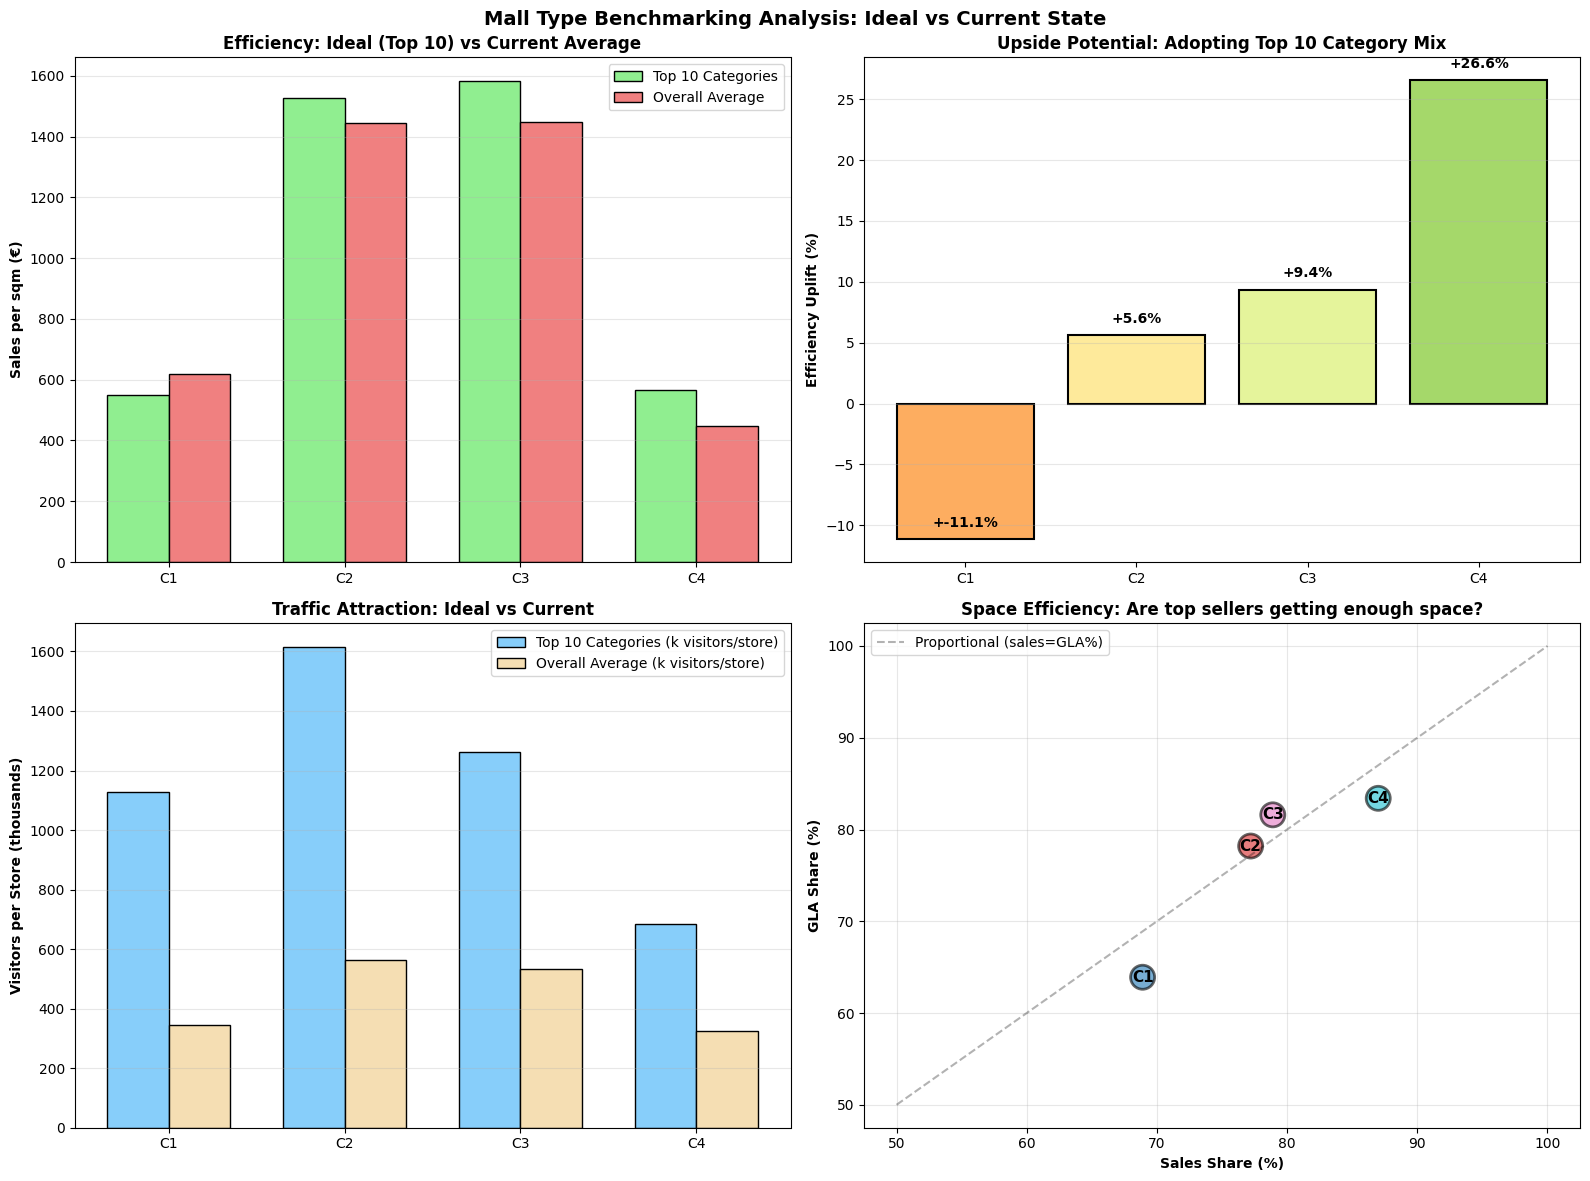


✅ Saved: 12_gap_analysis_ideal_vs_current.csv


FINAL REPORT: Ideal Tenant Composition Framework


MALL TYPE 0: Cluster 1: Medium traffic, general-purpose mall

📊 CURRENT STATE METRICS:
   Traffic: 36,154 visitors/day
   Dwell time: 51.7 minutes
   Sales per sqm: €721
   Margin rate: 88.7%
   Avg stores per mall: 721

✨ IDEAL TENANT MIX (Based on 14 core categories):

   Revenue Anchors (top categories to anchor the mall):
      1. Family Fashion: 17.8% sales | €338/sqm
      2. Hypermarkets: 9.3% sales | €406/sqm
      3. Electronics and household appliances: 8.8% sales | €1049/sqm

   Efficiency Leaders (highest sales per sqm):
      1. Auto Dealer: €4094/sqm | 0.5% sales
      2. Tobbaconists, lotteries and other activities: €3125/sqm | 0.8% sales
      3. Pharmacy: €2278/sqm | 1.8% sales

   Traffic Generators (highest visitors per store):
      1. Hypermarkets: 5781k visitors/store
      2. Department Stores: 1471k visitors/store
      3. Supermarkets: 1397k visitors/store

📈 COM

In [22]:
# PHASE 5: Benchmarking & Ideal vs Actual Gap Analysis
print(f"\n\n{'='*100}")
print("PHASE 5: Benchmarking Analysis - Ideal vs Current State")
print(f"{'='*100}\n")

# Create comparative analysis: ideal profile vs current average
gap_analysis = []

for cluster_id in sorted(ideal_profiles.keys()):
    data = ideal_profiles[cluster_id]
    bl2_metrics = data["bl2_metrics"]
    
    # Get top 10 categories (they form core)
    top10 = bl2_metrics.head(10)
    
    # Calculate metrics
    top10_avg_efficiency = top10["sales_per_sqm"].mean()
    overall_avg_efficiency = bl2_metrics["sales_per_sqm"].mean()
    top10_avg_traffic = top10["visitors_per_store"].mean()
    overall_avg_traffic = bl2_metrics["visitors_per_store"].mean()
    
    # Gap = opportunity
    efficiency_gap = ((top10_avg_efficiency / overall_avg_efficiency) - 1) * 100
    traffic_gap = ((top10_avg_traffic / overall_avg_traffic) - 1) * 100
    
    gap_analysis.append({
        "cluster": int(cluster_id),
        "profile": cluster_desc[cluster_id],
        "top10_avg_efficiency": top10_avg_efficiency,
        "overall_avg_efficiency": overall_avg_efficiency,
        "efficiency_gap_pct": efficiency_gap,
        "top10_avg_traffic": top10_avg_traffic,
        "overall_avg_traffic": overall_avg_traffic,
        "traffic_gap_pct": traffic_gap,
        "top10_gla_pct": top10["pct_gla"].sum(),
        "top10_sales_pct": top10["pct_sales"].sum(),
    })

gap_df = pd.DataFrame(gap_analysis)

print("Gap Analysis Summary (Top 10 Categories vs Overall Average):\n")
print(gap_df[[
    "cluster", "profile", "top10_avg_efficiency", "overall_avg_efficiency", "efficiency_gap_pct",
    "top10_sales_pct"
]].to_string(index=False))

# Visualization: Efficiency Benchmarking
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Mall Type Benchmarking Analysis: Ideal vs Current State", 
             fontsize=14, fontweight='bold')

# Chart 1: Efficiency Gap by Cluster
x_pos = range(len(gap_df))
width = 0.35

axes[0, 0].bar([p - width/2 for p in x_pos], gap_df["top10_avg_efficiency"], width, 
              label="Top 10 Categories", color="lightgreen", edgecolor="black")
axes[0, 0].bar([p + width/2 for p in x_pos], gap_df["overall_avg_efficiency"], width, 
              label="Overall Average", color="lightcoral", edgecolor="black")
axes[0, 0].set_ylabel("Sales per sqm (€)", fontweight='bold')
axes[0, 0].set_title("Efficiency: Ideal (Top 10) vs Current Average", fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([f"C{int(c)+1}" for c in gap_df["cluster"]])
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Chart 2: Efficiency Uplift Potential
colors_gap = plt.cm.RdYlGn(np.linspace(0.3, 0.7, len(gap_df)))
axes[0, 1].bar(x_pos, gap_df["efficiency_gap_pct"], color=colors_gap, edgecolor="black", linewidth=1.5)
axes[0, 1].set_ylabel("Efficiency Uplift (%)", fontweight='bold')
axes[0, 1].set_title("Upside Potential: Adopting Top 10 Category Mix", fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels([f"C{int(c)+1}" for c in gap_df["cluster"]])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(gap_df["efficiency_gap_pct"]):
    axes[0, 1].text(i, v + 1, f"+{v:.1f}%", ha='center', fontweight='bold', fontsize=10)

# Chart 3: Traffic Conversion Efficiency
axes[1, 0].bar([p - width/2 for p in x_pos], gap_df["top10_avg_traffic"]/1000, width, 
              label="Top 10 Categories (k visitors/store)", color="lightskyblue", edgecolor="black")
axes[1, 0].bar([p + width/2 for p in x_pos], gap_df["overall_avg_traffic"]/1000, width, 
              label="Overall Average (k visitors/store)", color="wheat", edgecolor="black")
axes[1, 0].set_ylabel("Visitors per Store (thousands)", fontweight='bold')
axes[1, 0].set_title("Traffic Attraction: Ideal vs Current", fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([f"C{int(c)+1}" for c in gap_df["cluster"]])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Chart 4: Space Allocation: Top 10 Categories vs their share
axes[1, 1].scatter(gap_df["top10_sales_pct"], gap_df["top10_gla_pct"], 
                  s=300, alpha=0.6, c=gap_df["cluster"], cmap="tab10", edgecolors="black", linewidth=2)
axes[1, 1].plot([50, 100], [50, 100], 'k--', alpha=0.3, label="Proportional (sales=GLA%)")
axes[1, 1].set_xlabel("Sales Share (%)", fontweight='bold')
axes[1, 1].set_ylabel("GLA Share (%)", fontweight='bold')
axes[1, 1].set_title("Space Efficiency: Are top sellers getting enough space?", fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Add cluster labels
for i, row in gap_df.iterrows():
    axes[1, 1].annotate(f"C{int(row['cluster'])+1}", 
                       (row["top10_sales_pct"], row["top10_gla_pct"]),
                       fontsize=11, fontweight='bold', ha='center', va='center')

plt.tight_layout()
plt.savefig(OUT_DIR / "figures" / "fig11_benchmarking_analysis.png", dpi=100, bbox_inches='tight')
plt.show()

gap_df.to_csv(OUT_DIR / "12_gap_analysis_ideal_vs_current.csv", index=False)

print("\n✅ Saved: 12_gap_analysis_ideal_vs_current.csv")

# PHASE 6: Executive Summary Report
print(f"\n\n{'='*100}")
print("FINAL REPORT: Ideal Tenant Composition Framework")
print(f"{'='*100}\n")

summary_report = []

for cluster_id in sorted(ideal_profiles.keys()):
    data = ideal_profiles[cluster_id]
    bl2_metrics = data["bl2_metrics"]
    profile = data["profile"]
    
    # Get best and worst categories
    best_cat = bl2_metrics.iloc[0]
    worst_cat = bl2_metrics.iloc[-1]
    core_cats = data["core_categories"]
    core_data = bl2_metrics.loc[core_cats]
    
    print(f"\n{'='*100}")
    print(f"MALL TYPE {int(cluster_id)}: {cluster_desc[cluster_id]}")
    print(f"{'='*100}")
    
    print(f"\n📊 CURRENT STATE METRICS:")
    print(f"   Traffic: {profile['cluster_traffic']:,.0f} visitors/day")
    print(f"   Dwell time: {profile['cluster_dwell_time']:.1f} minutes")
    print(f"   Sales per sqm: €{profile['cluster_sales_per_sqm']:.0f}")
    print(f"   Margin rate: {profile['cluster_margin_rate']:.1f}%")
    print(f"   Avg stores per mall: {profile['cluster_sales_per_sqm']:.0f}")
    
    print(f"\n✨ IDEAL TENANT MIX (Based on {len(core_cats)} core categories):")
    print(f"\n   Revenue Anchors (top categories to anchor the mall):")
    for i, (idx, row) in enumerate(bl2_metrics.head(3).iterrows(), 1):
        print(f"      {i}. {row['bl2_label']}: {row['pct_sales']:.1f}% sales | €{row['sales_per_sqm']:.0f}/sqm")
    
    print(f"\n   Efficiency Leaders (highest sales per sqm):")
    for i, (idx, row) in enumerate(bl2_metrics.nlargest(3, "sales_per_sqm").iterrows(), 1):
        print(f"      {i}. {row['bl2_label']}: €{row['sales_per_sqm']:.0f}/sqm | {row['pct_sales']:.1f}% sales")
    
    print(f"\n   Traffic Generators (highest visitors per store):")
    for i, (idx, row) in enumerate(bl2_metrics.nlargest(3, "visitors_per_store").iterrows(), 1):
        print(f"      {i}. {row['bl2_label']}: {row['visitors_per_store']/1000:.0f}k visitors/store")
    
    print(f"\n📈 COMPOSITION TARGETS:")
    print(f"   Core categories: {len(core_cats)} (achieving 80% of sales)")
    print(f"   Recommended store allocation: {core_data['pct_stores'].sum():.1f}%")
    print(f"   Recommended GLA allocation: {core_data['pct_gla'].sum():.1f}%")
    print(f"   Expected sales achievement: 80%")
    
    # Calculate potential upside
    top10_avg = bl2_metrics.head(10)["sales_per_sqm"].mean()
    current_avg = bl2_metrics["sales_per_sqm"].mean()
    uplift_potential = ((top10_avg / current_avg - 1) * 100)
    
    print(f"\n🚀 UPSIDE POTENTIAL:")
    print(f"   If top 10 categories' mix is optimized:")
    print(f"   • Efficiency uplift: +€{top10_avg - current_avg:.0f}/sqm (+{uplift_potential:.1f}%)")
    print(f"   • On {profile['cluster_sales_per_sqm'] * 10000 / current_avg:.0f} sqm average mall GLA:")
    print(f"   • Potential sales increase: €{(top10_avg - current_avg) * profile['cluster_sales_per_sqm'] * 10000 / current_avg / 1e6:.1f}M annually")
    
    summary_report.append({
        "Cluster": int(cluster_id),
        "Type": cluster_desc[cluster_id],
        "Core_Categories": len(core_cats),
        "Top_Revenue_Driver": best_cat['bl2_label'],
        "Recommended_Store_Mix_%": f"{core_data['pct_stores'].sum():.1f}%",
        "Recommended_GLA_Mix_%": f"{core_data['pct_gla'].sum():.1f}%",
        "Current_Avg_Efficiency_€/sqm": f"{current_avg:.0f}",
        "Top10_Avg_Efficiency_€/sqm": f"{top10_avg:.0f}",
        "Upside_Potential_%": f"{uplift_potential:.1f}%",
    })

# Create final summary table
summary_df = pd.DataFrame(summary_report)
summary_df.to_csv(OUT_DIR / "13_ideal_mix_executive_summary.csv", index=False)

print(f"\n\n{'='*100}")
print("SUMMARY TABLE")
print(f"{'='*100}\n")
print(summary_df.to_string(index=False))

print(f"\n\n{'='*100}")
print("✅ ANALYSIS COMPLETE!")
print(f"{'='*100}")
print(f"\nGenerated Files:")
print(f"  • 11_ideal_tenant_mix_profile.csv - Core profile data")
print(f"  • 12_gap_analysis_ideal_vs_current.csv - Gap analysis")
print(f"  • 13_ideal_mix_executive_summary.csv - Executive summary")
print(f"  • fig10_cluster_*_ideal_profile.png - Visual profiles (×4)")
print(f"  • fig11_benchmarking_analysis.png - Benchmarking charts")



BONUS: Three Roles Classification Framework - Clean Presentation

Creating Three Roles Analysis across all clusters...



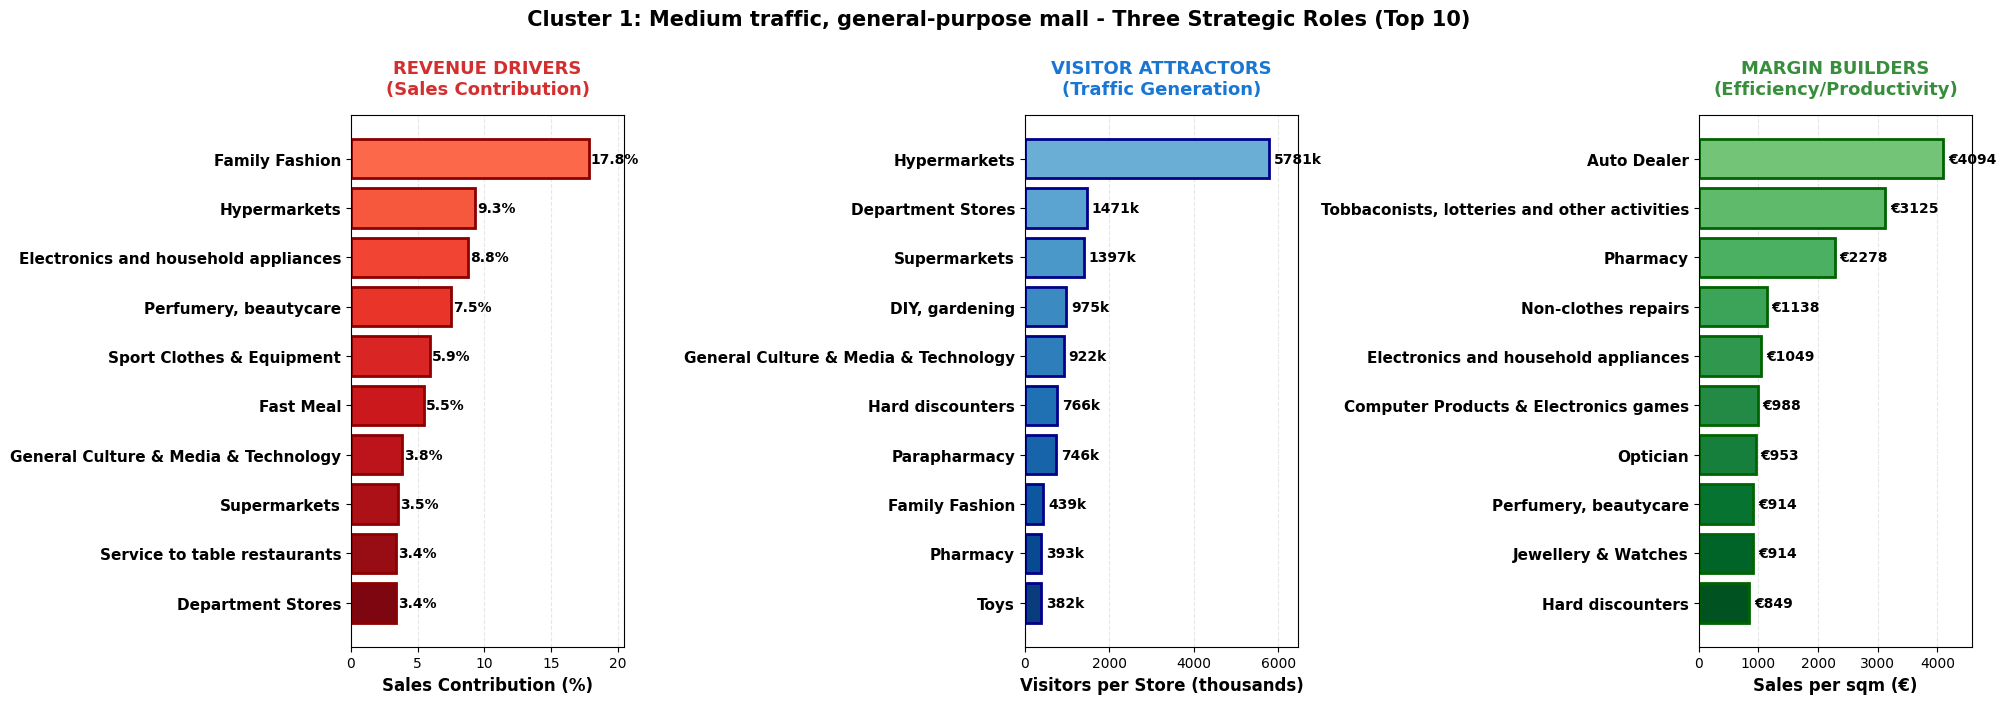

   ✅ Cluster 1: Cluster 1: Medium traffic, general-purpose mall
      • Top Revenue Driver: Family Fashion (17.8%)
      • Top Traffic Generator: Hypermarkets (5781k visitors/store)
      • Top Efficiency Leader: Auto Dealer (€4094/sqm)


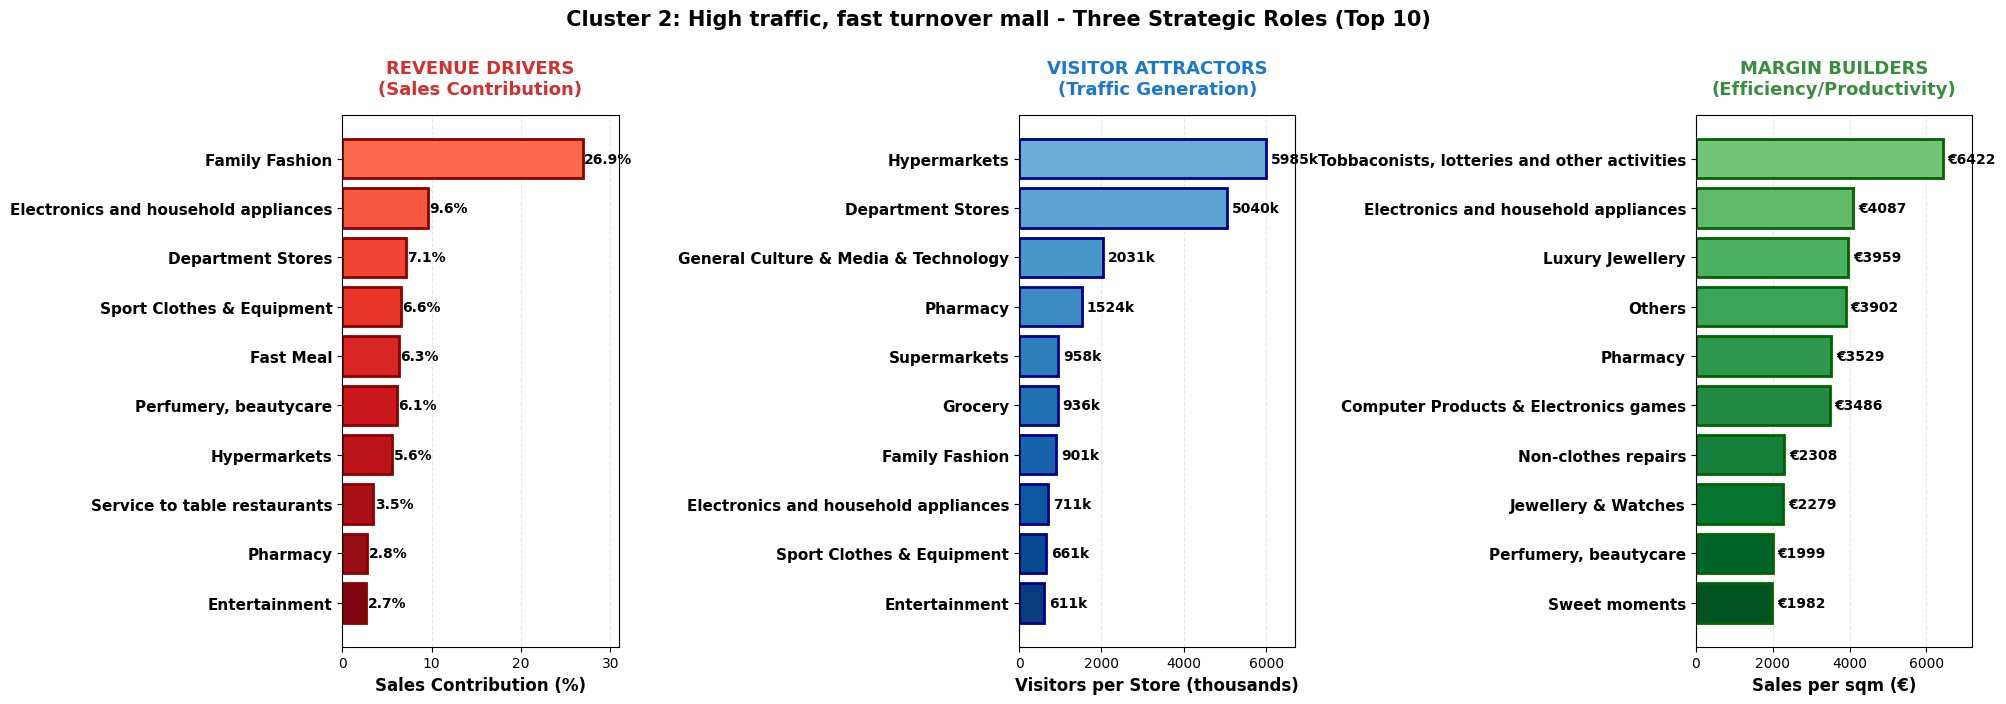

   ✅ Cluster 2: Cluster 2: High traffic, fast turnover mall
      • Top Revenue Driver: Family Fashion (26.9%)
      • Top Traffic Generator: Hypermarkets (5985k visitors/store)
      • Top Efficiency Leader: Tobbaconists, lotteries and other activities (€6422/sqm)


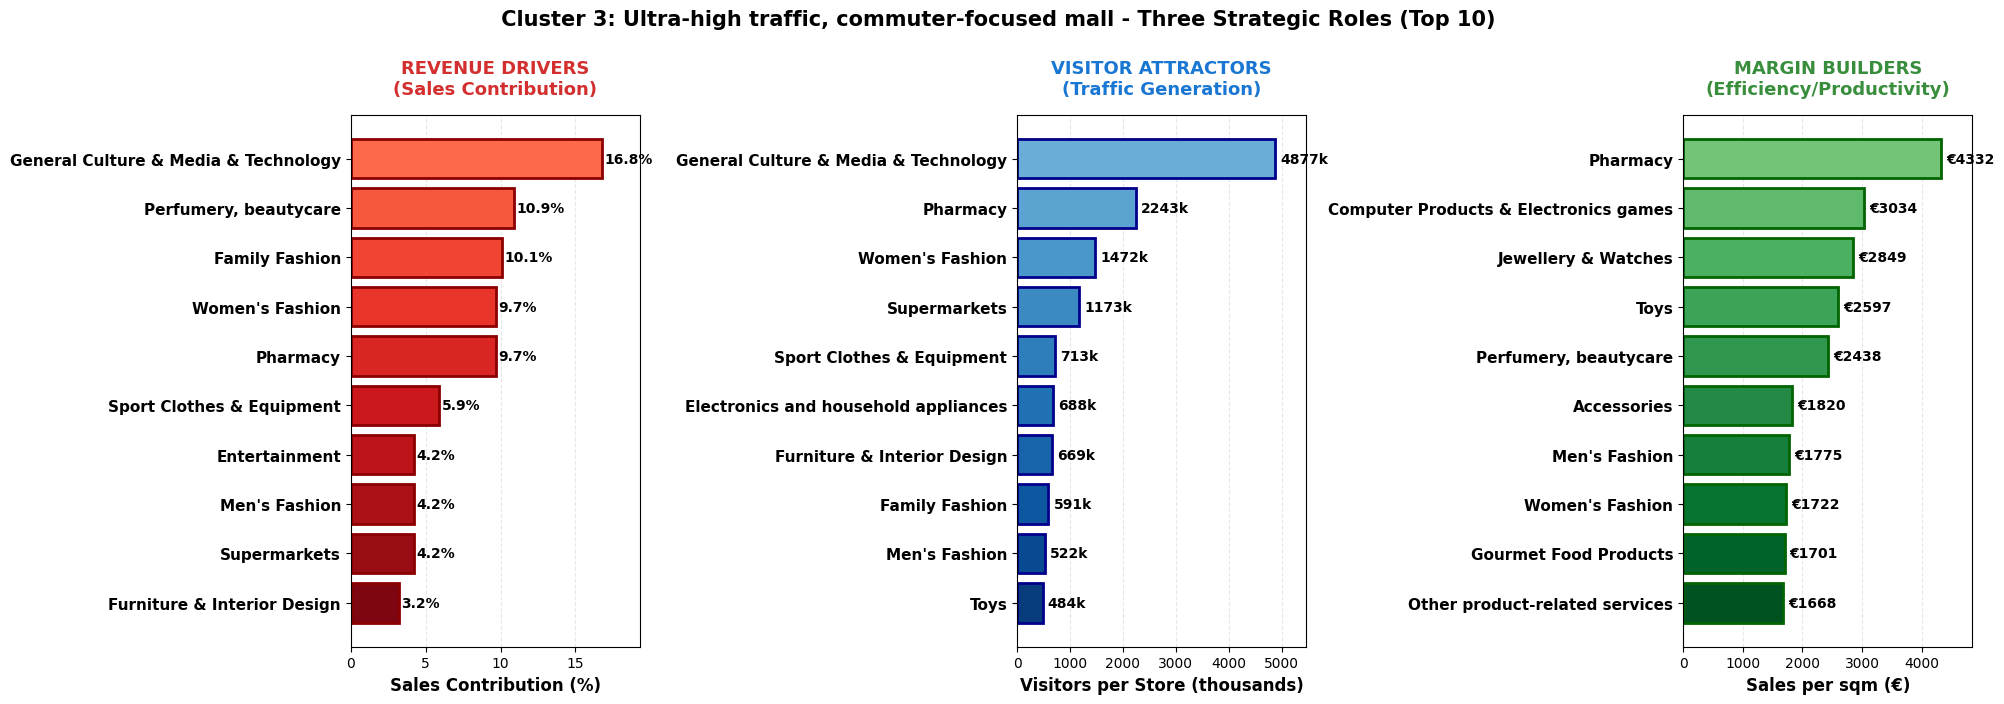

   ✅ Cluster 3: Cluster 3: Ultra-high traffic, commuter-focused mall
      • Top Revenue Driver: General Culture & Media & Technology (16.8%)
      • Top Traffic Generator: General Culture & Media & Technology (4877k visitors/store)
      • Top Efficiency Leader: Pharmacy (€4332/sqm)


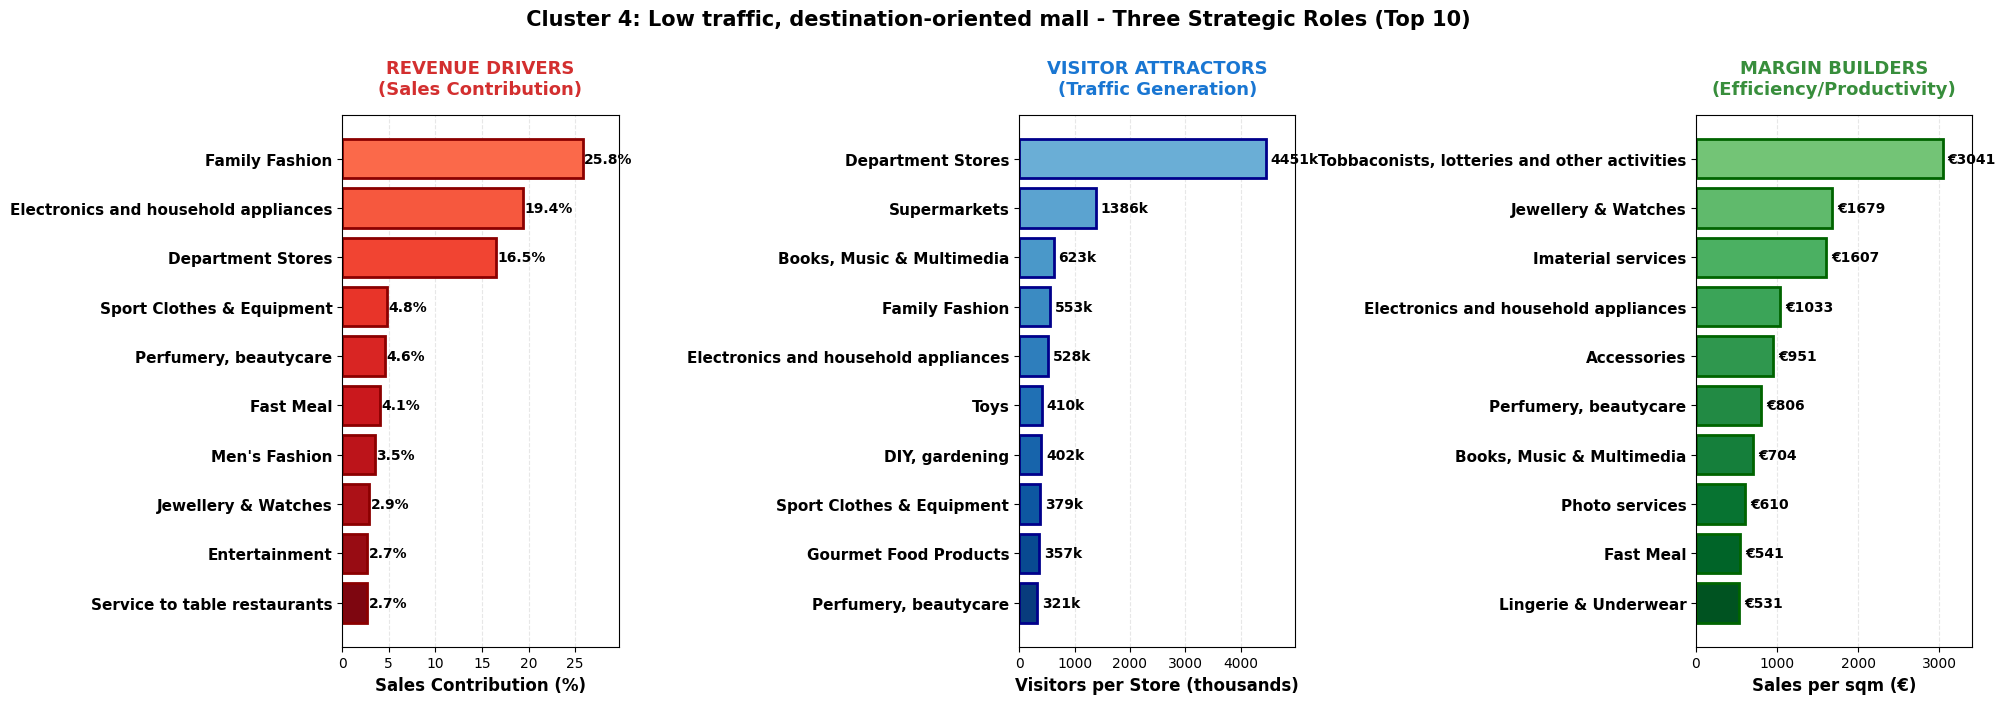

   ✅ Cluster 4: Cluster 4: Low traffic, destination-oriented mall
      • Top Revenue Driver: Family Fashion (25.8%)
      • Top Traffic Generator: Department Stores (4451k visitors/store)
      • Top Efficiency Leader: Tobbaconists, lotteries and other activities (€3041/sqm)


SUMMARY: Strategic Role Leaders Across All Clusters

 Cluster                                            Mall Type                             💰 Revenue Leader                             👥 Traffic Leader                                      📈 Efficiency Leader
       0      Cluster 1: Medium traffic, general-purpose mall                       Family Fashion (17.8%)                         Hypermarkets (5781k)                                  Auto Dealer (€4094/sqm)
       1          Cluster 2: High traffic, fast turnover mall                       Family Fashion (26.9%)                         Hypermarkets (5985k) Tobbaconists, lotteries and other activities (€6422/sqm)
       2 Cluster 3: Ultra-high traffic, c

In [23]:
# BONUS: Three Roles Framework Visualization - Clean & Professional for Presentation
print(f"\n\n{'='*100}")
print("BONUS: Three Roles Classification Framework - Clean Presentation")
print(f"{'='*100}\n")

# Create clean, professional visualization for client presentation
# Strategy: Show three key dimensions separately for clarity

print("Creating Three Roles Analysis across all clusters...\n")

for cluster_id in sorted(ideal_profiles.keys()):
    data = ideal_profiles[cluster_id]
    bl2_metrics = data["bl2_metrics"].copy()
    
    # Prepare data for three roles
    revenue_top = bl2_metrics.nlargest(10, "pct_sales")[["bl2_label", "pct_sales"]].reset_index(drop=True)
    traffic_top = bl2_metrics.nlargest(10, "visitors_per_store")[["bl2_label", "visitors_per_store"]].reset_index(drop=True)
    efficiency_top = bl2_metrics.nlargest(10, "sales_per_sqm")[["bl2_label", "sales_per_sqm"]].reset_index(drop=True)
    
    # Create figure with three subplots - one for each role
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    fig.suptitle(f" {cluster_desc[cluster_id]} - Three Strategic Roles (Top 10)", 
                 fontsize=15, fontweight='bold', y=1.00)
    
    # ============== ROLE 1: REVENUE DRIVERS ==============
    colors_revenue = plt.cm.Reds(np.linspace(0.5, 0.95, len(revenue_top)))
    bars1 = axes[0].barh(range(len(revenue_top)), revenue_top["pct_sales"].values, 
                         color=colors_revenue, edgecolor="darkred", linewidth=2)
    axes[0].set_yticks(range(len(revenue_top)))
    axes[0].set_yticklabels(revenue_top["bl2_label"].values, fontsize=11, fontweight='bold')
    axes[0].set_xlabel("Sales Contribution (%)", fontsize=12, fontweight='bold')
    axes[0].set_title("REVENUE DRIVERS\n(Sales Contribution)", fontsize=13, fontweight='bold', 
                     color="#D32F2F", pad=15)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.8)
    axes[0].set_axisbelow(True)
    # Add value labels
    for i, v in enumerate(revenue_top["pct_sales"].values):
        axes[0].text(v + 0.15, i, f"{v:.1f}%", va='center', fontweight='bold', fontsize=10)
    axes[0].set_xlim(0, revenue_top["pct_sales"].max() * 1.15)
    
    # ============== ROLE 2: VISITOR ATTRACTORS ==============
    traffic_top["visitors_k"] = traffic_top["visitors_per_store"] / 1000
    colors_traffic = plt.cm.Blues(np.linspace(0.5, 0.95, len(traffic_top)))
    bars2 = axes[1].barh(range(len(traffic_top)), traffic_top["visitors_k"].values, 
                         color=colors_traffic, edgecolor="darkblue", linewidth=2)
    axes[1].set_yticks(range(len(traffic_top)))
    axes[1].set_yticklabels(traffic_top["bl2_label"].values, fontsize=11, fontweight='bold')
    axes[1].set_xlabel("Visitors per Store (thousands)", fontsize=12, fontweight='bold')
    axes[1].set_title("VISITOR ATTRACTORS\n(Traffic Generation)", fontsize=13, fontweight='bold', 
                     color="#1976D2", pad=15)
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.8)
    axes[1].set_axisbelow(True)
    # Add value labels
    for i, v in enumerate(traffic_top["visitors_k"].values):
        axes[1].text(v + traffic_top["visitors_k"].max() * 0.02, i, f"{v:.0f}k", 
                    va='center', fontweight='bold', fontsize=10)
    axes[1].set_xlim(0, traffic_top["visitors_k"].max() * 1.12)
    
    # ============== ROLE 3: MARGIN BUILDERS ==============
    colors_efficiency = plt.cm.Greens(np.linspace(0.5, 0.95, len(efficiency_top)))
    bars3 = axes[2].barh(range(len(efficiency_top)), efficiency_top["sales_per_sqm"].values, 
                         color=colors_efficiency, edgecolor="darkgreen", linewidth=2)
    axes[2].set_yticks(range(len(efficiency_top)))
    axes[2].set_yticklabels(efficiency_top["bl2_label"].values, fontsize=11, fontweight='bold')
    axes[2].set_xlabel("Sales per sqm (€)", fontsize=12, fontweight='bold')
    axes[2].set_title("MARGIN BUILDERS\n(Efficiency/Productivity)", fontsize=13, fontweight='bold', 
                     color="#388E3C", pad=15)
    axes[2].invert_yaxis()
    axes[2].grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.8)
    axes[2].set_axisbelow(True)
    # Add value labels
    for i, v in enumerate(efficiency_top["sales_per_sqm"].values):
        axes[2].text(v + efficiency_top["sales_per_sqm"].max() * 0.02, i, f"€{v:.0f}", 
                    va='center', fontweight='bold', fontsize=10)
    axes[2].set_xlim(0, efficiency_top["sales_per_sqm"].max() * 1.12)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(OUT_DIR / "figures" / f"fig12_cluster_{int(cluster_id)}_three_roles.png", 
               dpi=120, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Cluster {int(cluster_id)+1}: {cluster_desc[cluster_id]}")
    print(f"      • Top Revenue Driver: {revenue_top.iloc[0]['bl2_label']} ({revenue_top.iloc[0]['pct_sales']:.1f}%)")
    print(f"      • Top Traffic Generator: {traffic_top.iloc[0]['bl2_label']} ({traffic_top.iloc[0]['visitors_k']:.0f}k visitors/store)")
    print(f"      • Top Efficiency Leader: {efficiency_top.iloc[0]['bl2_label']} (€{efficiency_top.iloc[0]['sales_per_sqm']:.0f}/sqm)")

# Create a summary comparison table
print(f"\n\n{'='*100}")
print("SUMMARY: Strategic Role Leaders Across All Clusters")
print(f"{'='*100}\n")

role_summary = []
for cluster_id in sorted(ideal_profiles.keys()):
    data = ideal_profiles[cluster_id]
    bl2_metrics = data["bl2_metrics"]
    
    revenue_leader = bl2_metrics.nlargest(1, "pct_sales").iloc[0]
    traffic_leader = bl2_metrics.nlargest(1, "visitors_per_store").iloc[0]
    efficiency_leader = bl2_metrics.nlargest(1, "sales_per_sqm").iloc[0]
    
    role_summary.append({
        "Cluster": int(cluster_id),
        "Mall Type": cluster_desc[cluster_id],
        "💰 Revenue Leader": f"{revenue_leader['bl2_label']} ({revenue_leader['pct_sales']:.1f}%)",
        "👥 Traffic Leader": f"{traffic_leader['bl2_label']} ({traffic_leader['visitors_per_store']/1000:.0f}k)",
        "📈 Efficiency Leader": f"{efficiency_leader['bl2_label']} (€{efficiency_leader['sales_per_sqm']:.0f}/sqm)"
    })

role_df = pd.DataFrame(role_summary)
print(role_df.to_string(index=False))

role_df.to_csv(OUT_DIR / "14_three_roles_leaders.csv", index=False)

print(f"\n\n{'='*100}")
print("✅ THREE ROLES ANALYSIS COMPLETE!")
print(f"{'='*100}")
print(f"\nGenerated Files:")
print(f"  • fig12_cluster_*_three_roles.png - Clean role analysis for each cluster (×4)")
print(f"  • 14_three_roles_leaders.csv - Summary table of role leaders by cluster")
print(f"\n📊 Key Insights for Client Presentation:")
print(f"  💰 REVENUE DRIVERS: Categories driving 80% of sales")
print(f"     → Focus strategy on optimal mix of these proven performers")
print(f"     → These should have premium location and visibility")
print(f"\n  👥 VISITOR ATTRACTORS: Categories generating foot traffic")
print(f"     → Place strategically to maximize mall flow")
print(f"     → Anchor positions for foot traffic routes")
print(f"\n  📈 MARGIN BUILDERS: Categories maximizing space efficiency")
print(f"     → Highest sales per sqm - premium space allocation")
print(f"     → Often overlap with revenue drivers - the 'powerhouses'")
print(f"\n✨ Best Practice:")
print(f"  Look for categories excelling in MULTIPLE roles:")
print(f"  - Revenue + Traffic = Traffic magnet that drives sales")
print(f"  - Revenue + Efficiency = Cash cow with strong margins")
print(f"  - All three = Strategic cornerstone category")